In [1]:
#microphone check one two what is this!

In [18]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from statsmodels.tsa.statespace.sarimax import SARIMAX #pip install statsmodels
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

#from thefuzz import process - not needed anymore

import matplotlib.pyplot as plt
import packaging as p

import os, requests
from datetime import date, timedelta, time, datetime
from contextlib import contextmanager

In [19]:
#global parameters
LOOKAHEAD_DAYS = 28
COMMUTE_WINDOWS = [(7,10),(16,19)]
LOCAL_TZ = 'Europe/London'
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [20]:
'''#check counts and names
import pandas as pd, re
from pprint import pprint

xl = pd.ExcelFile("multi-year-station-entry-and-exit-figures.xlsx")

def norm(s): 
    import re
    s = str(s).lower().strip()
    s = re.sub(r"[^a-z0-9]+", " ", s)
    return re.sub(r"\s+", " ", s).strip()

def find_header_row(xl, sheet, scan_rows=60):
    raw = xl.parse(sheet, header=None)
    for i in range(min(scan_rows, len(raw))):
        row = [norm(v) for v in raw.iloc[i].tolist()]
        if any("station" in v for v in row) or (any("entr" in v for v in row) and any("exit" in v for v in row)):
            return i
    return None

s = "2017 Entry & Exit"
hdr = find_header_row(xl, s)
df = xl.parse(s, header=hdr).dropna(how="all").dropna(axis=1, how="all")
pprint([norm(c) for c in df.columns])'''

'#check counts and names\nimport pandas as pd, re\nfrom pprint import pprint\n\nxl = pd.ExcelFile("multi-year-station-entry-and-exit-figures.xlsx")\n\ndef norm(s): \n    import re\n    s = str(s).lower().strip()\n    s = re.sub(r"[^a-z0-9]+", " ", s)\n    return re.sub(r"\\s+", " ", s).strip()\n\ndef find_header_row(xl, sheet, scan_rows=60):\n    raw = xl.parse(sheet, header=None)\n    for i in range(min(scan_rows, len(raw))):\n        row = [norm(v) for v in raw.iloc[i].tolist()]\n        if any("station" in v for v in row) or (any("entr" in v for v in row) and any("exit" in v for v in row)):\n            return i\n    return None\n\ns = "2017 Entry & Exit"\nhdr = find_header_row(xl, s)\ndf = xl.parse(s, header=hdr).dropna(how="all").dropna(axis=1, how="all")\npprint([norm(c) for c in df.columns])'

In [21]:
#figure helper for slide deck 001 

FIGS = Path("figures"); FIGS.mkdir(parents=True, exist_ok=True)

FIGMETA = {"lookahead": LOOKAHEAD_DAYS, "tz": LOCAL_TZ, "now_df": None, "plan_df": None}

def meta_with(**kwargs):
    m = FIGMETA.copy()
    m.update(kwargs)
    return m

def _make_bullets(meta):
    import pandas as pd
    bullets = []
    look = meta.get("lookahead"); tz = meta.get("tz", "Europe/London")
    if look: bullets.append(f"Window: next {look} days ({tz}).")

    now_df = meta.get("now_df")
    if now_df is not None and hasattr(now_df, "empty") and not now_df.empty:
        if "severity" in now_df.columns:
            pct_good = (now_df["severity"] == 10).mean() * 100
            bullets.append(f"Right now: {pct_good:.0f}% of lines report Good Service.")
            worst_now = now_df[now_df["severity"] < 10].sort_values("severity").head(3)
            if not worst_now.empty and {"line","status"}.issubset(worst_now.columns):
                bullets.append("Worst now: " + ", ".join(f"{r['line']} ({r['status']})" for _, r in worst_now.iterrows()))

    plan_df = meta.get("plan_df")
    by_line = meta.get("by_line")
    if plan_df is not None and hasattr(plan_df, "empty") and not plan_df.empty:
        _tmp = plan_df.copy()
        if "from" in _tmp.columns and "to" in _tmp.columns:
            delta = (_tmp["to"] - _tmp["from"]).dt.total_seconds() / 3600.0
        elif "from_local" in _tmp.columns and "to_local" in _tmp.columns:
            delta = (_tmp["to_local"] - _tmp["from_local"]).dt.total_seconds() / 3600.0
        else:
            delta = None
        if delta is not None:
            tot_h = float(delta.fillna(0).sum())
            bullets.append(f"Planned disruption hours in window: ~{tot_h:.1f}.")
        if by_line is None and "line" in _tmp.columns and delta is not None:
            _tmp["hours"] = delta
            by_line = (_tmp.groupby("line", as_index=False)["hours"].sum()
                            .sort_values("hours", ascending=False))
        if by_line is not None and not by_line.empty:
            bullets.append(f"Most impacted line (planned): {by_line.iloc[0]['line']} (~{by_line.iloc[0]['hours']:.1f} h).")

    if "hotspot" in meta and meta["hotspot"]:
        bullets.append(f"Top hotspot: {meta['hotspot']}.")

    return bullets

@contextmanager
def slide_figure(filename, title=None, meta=None, figsize=(10, 4), dpi=220):
    import pandas as pd, matplotlib.pyplot as plt
    if meta is None:
        meta = FIGMETA
    fig = plt.figure(figsize=figsize)
    try:
        if title: plt.title(title)
        yield fig
    finally:
        stamp = f"Generated {pd.Timestamp.now(tz=LOCAL_TZ):%d %b %Y %H:%M %Z} | Lookahead: {FIGMETA.get('lookahead')} days"
        try:
            plt.suptitle(stamp, fontsize=8, y=0.99)
        except Exception:
            pass
        plt.tight_layout()
        out = FIGS / filename
        plt.savefig(out, dpi=dpi)
        plt.show()
        #bullets
        bullets = _make_bullets(meta)
        if bullets:
            print("Slide bullets:")
            for b in bullets: print("•", b)

In [22]:
#paths
RAW_STATION_XLSX   = "multi-year-station-entry-and-exit-figures.xlsx"
RAW_STATIONS_CSV   = "TfL_stations.csv"
RAW_PERF_XLSX      = "tfl-tube-performance.xlsx"

OUT_DIR            = "data/processed"
OUT_STATION_FLOW   = f"{OUT_DIR}/station_flow_clean_basic.csv"
OUT_STATIONS_CLEAN = f"{OUT_DIR}/TfL_stations_clean.csv"
OUT_PERF_CLEAN     = f"{OUT_DIR}/tube_performance_clean_basic.csv"

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

#cleanin file #1:
def clean_station_workbook(xlsx_path: str) -> pd.DataFrame:
    xl = pd.ExcelFile(xlsx_path)
    frames = []
    
    target_sheets = [s for s in xl.sheet_names if ("entry" in s.lower() and "exit" in s.lower())]
    for s in target_sheets:
        raw = xl.parse(s, header=None) #raw read+ drop empty rows/cols
        raw = raw.dropna(how="all").dropna(axis=1, how="all")
        if raw.empty:
            continue

        df = raw.copy()
        df.columns = [f"col{i}" for i in range(df.shape[1])] #assume first column holds station names
        
        for c in df.columns[1:]:
            df[c] = pd.to_numeric(df[c], errors="coerce") #coerce non first columns to numeric

        num_cols = [c for c in df.columns[1:] if np.issubdtype(df[c].dtype, np.number)]
        if not num_cols:
            continue
        q90 = {c: df[c].quantile(0.90) for c in num_cols}
        total_col = max(q90, key=lambda k: (q90[k] if pd.notna(q90[k]) else -np.inf)) #choose total as numeric column with highest 90th %

        out = pd.DataFrame({
            "station": df["col0"].astype(str).str.strip().str.title(),
            "annual_entries_exits": df[total_col]})

        out = out.replace({"": np.nan, "nan": np.nan})
        out = out[~out["station"].str.contains(r"^total\b|^counts\b|^grand\b", case=False, na=False)]
        out = out.dropna(subset=["station", "annual_entries_exits"]) #drop junk

        if out["annual_entries_exits"].max(skipna=True) < 100_000:
            out["annual_entries_exits"] = out["annual_entries_exits"] * 1_000_000 #millions to absolute
            
        out["daily_avg_passengers"] = out["annual_entries_exits"] / 365.0 #daily average

        m = re.search(r"(20\d{2})", s)
        out["year"] = int(m.group(1)) if m else np.nan
        
        frames.append(out[["year","station","annual_entries_exits","daily_avg_passengers"]])

    if not frames:
        raise RuntimeError("Station workbook: produced no rows. Check file path or sheet names.")

    station_flow = pd.concat(frames, ignore_index=True).drop_duplicates()
    return station_flow

station_flow = clean_station_workbook(RAW_STATION_XLSX)
station_flow.to_csv(OUT_STATION_FLOW, index=False)
print(f"Wrote {OUT_STATION_FLOW}  rows={len(station_flow)}")
display(station_flow.head(10))


#cleanin file #2:
def clean_stations_csv(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df.columns = [re.sub(r"_+", "_", re.sub(r"[^0-9a-zA-Z]+", "_", c)).strip("_").lower() for c in df.columns] #normalize headers
    
    rename_map = {}
    for cand in ["station", "name", "station_name"]:
        if cand in df.columns:
            rename_map[cand] = "station" #pick common columns
            break
    for cand in ["line", "lines"]:
        if cand in df.columns:
            rename_map[cand] = "line"
            break
    for cand in ["latitude","lat"]:
        if cand in df.columns:
            rename_map[cand] = "lat"
            break
    for cand in ["longitude","lon","lng","long"]:
        if cand in df.columns:
            rename_map[cand] = "lon"
            break
    if rename_map:
        df = df.rename(columns=rename_map)

    if "station" in df.columns:
        df["station"] = df["station"].astype(str).str.strip().str.title()
    if "line" in df.columns:
        df["line"] = df["line"].astype(str).str.strip().str.title()

    for c in ["lat","lon"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce") #lat/lon

    keep = [c for c in ["station","line","lat","lon","borough","zone"] if c in df.columns]
    if keep:
        df = df[keep] #keep useful columns

    df = df.drop_duplicates().dropna(how="all")
    return df

stations_clean = clean_stations_csv(RAW_STATIONS_CSV)
stations_clean.to_csv(OUT_STATIONS_CLEAN, index=False)
print(f"Wrote {OUT_STATIONS_CLEAN}  rows={len(stations_clean)}")
display(stations_clean.head(10))


#cleanin file #3:
def clean_tube_performance(xlsx_path: str) -> pd.DataFrame:
    xl = pd.ExcelFile(xlsx_path)
    frames = []
    for s in xl.sheet_names:
        df = xl.parse(s, header=0).dropna(how="all").dropna(axis=1, how="all")
        if df.shape[1] < 2:
            continue
        
        cols_norm = [re.sub(r"\s+", " ", str(c).strip().lower()) for c in df.columns]
        cmap = {cn: c for cn, c in zip(cols_norm, df.columns)} #normalize headers

        line_col = None
        for key in ["line", "line name", "route"]:
            hit = [cmap[k] for k in list(cmap) if key in k]
            if hit:
                line_col = hit[0]; break
        if line_col is None:
            obj = df.select_dtypes(exclude=[np.number]).columns
            if len(obj) == 0: 
                continue
            line_col = obj[0] #line column?

        date_series = None
        for key in ["period start","start date","date"]:
            hit = [cmap[k] for k in list(cmap) if key in k]
            if hit:
                date_series = pd.to_datetime(df[hit[0]], errors="coerce"); break
        if date_series is None and ("year" in cmap and "month" in cmap):
            y = pd.to_numeric(df[cmap["year"]], errors="coerce")
            m = pd.to_numeric(df[cmap["month"]], errors="coerce")
            date_series = pd.to_datetime(dict(year=y, month=m, day=1), errors="coerce") #date column?

        metric_col = None
        for key in ["excess journey time","ejt","lost customer hours","lch"]:
            hit = [cmap[k] for k in list(cmap) if key in k]
            if hit:
                metric_col = hit[0]; break
        if metric_col is None:
            num = df.select_dtypes(include=[np.number]).columns
            if len(num) == 0: 
                continue
            var = pd.Series({c: pd.to_numeric(df[c], errors="coerce").var(skipna=True) for c in num})
            metric_col = var.sort_values(ascending=False).index[0] #metric column?

        tidy = pd.DataFrame({
            "line": df[line_col].astype(str).str.replace(" line","", case=False).str.title().str.strip(),
            "metric": pd.to_numeric(df[metric_col], errors="coerce")})
        if date_series is not None:
            tidy["date"] = pd.to_datetime(date_series, errors="coerce").dt.to_period("M").dt.to_timestamp()
        else:
            tidy["date"] = pd.NaT

        tidy = tidy.dropna(subset=["line"]).drop_duplicates()
        frames.append(tidy[["line","date","metric"]])

    if not frames:
        raise RuntimeError("Performance workbook: produced no rows. Check file path or sheet contents.")
    merged = pd.concat(frames, ignore_index=True)
    # collapse duplicates on same (line,date) by mean
    merged["date"] = pd.to_datetime(merged["date"], errors="coerce")
    merged = (merged.groupby(["line","date"], as_index=False).agg(metric=("metric","mean")))
    return merged

perf_clean = clean_tube_performance(RAW_PERF_XLSX)
perf_clean.to_csv(OUT_PERF_CLEAN, index=False)
print(f"Wrote {OUT_PERF_CLEAN}  rows={len(perf_clean)}")
display(perf_clean.head(10))

Wrote data/processed/station_flow_clean_basic.csv  rows=2968


,year,station,annual_entries_exits,daily_avg_passengers
0,2017,Nan,253.0,0.693151
1,2017,625,149150.0,408.630137
2,2017,747,147574.0,404.312329
3,2017,669,121364.0,332.504110
4,2017,741,121018.0,331.556164
5,2017,635,113606.0,311.249315
6,2017,634,112437.0,308.046575
7,2017,719,93742.0,256.827397
8,2017,513,112547.0,308.347945
9,2017,852,86663.0,237.432877


Wrote data/processed/TfL_stations_clean.csv  rows=436


,station,line
0,Acton Town,"District, Piccadilly"
1,Barbican,"Circle, Hammersmith & City, Metropolitan"
2,Aldgate,"Circle, Metropolitan"
3,Aldgate East,"District, Hammersmith & City"
4,Alperton,Piccadilly
5,Amersham,Metropolitan
6,Angel,Northern
7,Archway,Northern
8,Arnos Grove,Piccadilly
9,Arsenal,Piccadilly


Wrote data/processed/tube_performance_clean_basic.csv  rows=0


,line,date,metric


In [23]:
#paths and imports
RAW_DIR = Path("data/processed")  #new cleaned CSVs

STATION_FLOW_CSV   = RAW_DIR / "station_flow_clean_basic.csv"
STATIONS_CLEAN_CSV = RAW_DIR / "TfL_stations_clean.csv"
PERF_CLEAN_CSV     = RAW_DIR / "tube_performance_clean_basic.csv"

OUT_DIR = Path("data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [24]:
#load + sanity check
station_flow   = pd.read_csv(STATION_FLOW_CSV)
stations_ref   = pd.read_csv(STATIONS_CLEAN_CSV)
perf_clean     = pd.read_csv(PERF_CLEAN_CSV, parse_dates=["date"])

print("station_flow:", station_flow.shape, station_flow.columns.tolist())
print("stations_ref:", stations_ref.shape, stations_ref.columns.tolist())
print("perf_clean:",   perf_clean.shape,   perf_clean.columns.tolist())

display(station_flow.head(3))
display(stations_ref.head(3))
display(perf_clean.head(3))

station_flow: (2968, 4) ['year', 'station', 'annual_entries_exits', 'daily_avg_passengers']
stations_ref: (436, 2) ['station', 'line']
perf_clean: (0, 3) ['line', 'date', 'metric']


,year,station,annual_entries_exits,daily_avg_passengers
0,2017,Nan,253.0,0.693151
1,2017,625,149150.0,408.630137
2,2017,747,147574.0,404.312329


,station,line
0,Acton Town,"District, Piccadilly"
1,Barbican,"Circle, Hammersmith & City, Metropolitan"
2,Aldgate,"Circle, Metropolitan"


,line,date,metric


Using sheet: Key trends | metric: Operated Kms (Peak and Off Peak) | line_col: None→Network | date: synthetic-date
modelling line: Network
{'MAE': 206593.58844530652, 'MAPE': 0.03323625454652527}


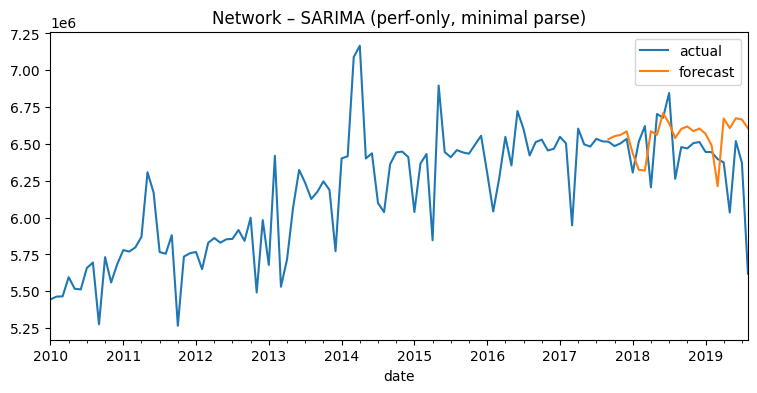

In [25]:
RAW_PERF_XLSX = Path("tfl-tube-performance.xlsx")  #raw workbook
HAS_PERF = RAW_PERF_XLSX.exists()

if not HAS_PERF:
    print ("Skipping performance modelling as tfl-tube-performance.xlsx not found")
    
    
#minimal builder - pull  from workbook
def build_perf_minimal(xlsx_path: str) -> pd.DataFrame:
    xl = pd.ExcelFile(xlsx_path)
    chosen = None
    for s in xl.sheet_names:
        df = xl.parse(s, header=0).dropna(how="all").dropna(axis=1, how="all")
        if df.shape[1] < 2: continue
        #normalise headers/ simple lookups
        cols_norm = [re.sub(r"\s+", " ", str(c).strip().lower()) for c in df.columns]
        cmap = {cn: c for cn, c in zip(cols_norm, df.columns)}

        num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if not num_cols: 
            #coerce everything except first text-like col
            for c in df.columns[1:]: df[c] = pd.to_numeric(df[c], errors="coerce")
            num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if not num_cols: 
            continue

        #pick metric = numeric col with largest variance - can skip obvious keys?
        skip = {cmap[k] for k in cmap if k in {"year","month","period"}} & set(df.columns)
        cand = [c for c in num_cols if c not in skip]
        if not cand: cand = num_cols
        var = pd.Series({c: pd.to_numeric(df[c], errors="coerce").var(skipna=True) for c in cand})
        metric_col = var.sort_values(ascending=False).index[0]

        #line column? - this is a test, not needed. update: it works!
        line_col = None
        for key in ["line", "line name", "route"]:
            hit = [cmap[k] for k in cmap if key in k]
            if hit: line_col = hit[0]; break

        #date column? this is a test, not needed. update: it works!
        date_s = None
        for key in ["period start","start date","date"]:
            hit = [cmap[k] for k in cmap if key in k]
            if hit:
                try:
                    date_s = pd.to_datetime(df[hit[0]], errors="coerce")
                except Exception:
                    date_s = None
                break
        if date_s is None and "year" in cmap and "month" in cmap:
            y = pd.to_numeric(df[cmap["year"]], errors="coerce")
            m = pd.to_numeric(df[cmap["month"]], errors="coerce")
            date_s = pd.to_datetime(dict(year=y, month=m, day=1), errors="coerce")

        #build tidy
        tidy = pd.DataFrame({
            "line": (df[line_col].astype(str) if line_col else "Network"),
            "metric": pd.to_numeric(df[metric_col], errors="coerce")})
        if date_s is not None:
            tidy["date"] = pd.to_datetime(date_s, errors="coerce")
        else:
            #synthetic monthly index starting at jan of plausible yr? 
            n = len(tidy)
            start_year = 2010
            tidy["date"] = pd.date_range(f"{start_year}-01-01", periods=n, freq="MS")

        #cleaning
        tidy = (tidy.replace({"": np.nan, "nan": np.nan}).dropna(subset=["metric"]).assign(line=lambda d: d["line"].astype(str).str.replace(" line","", case=False).str.title().str.strip()))
        tidy["date"] = pd.to_datetime(tidy["date"], errors="coerce").dt.to_period("M").dt.to_timestamp()
        if tidy.empty: 
            continue

        chosen = (s, metric_col, line_col, "real-date" if date_s is not None else "synthetic-date", tidy)
        break

    if chosen is None:
        raise RuntimeError("Could not find any usable numeric series in the performance workbook.")
    s, metric_col, line_col, date_mode, tidy = chosen
    print(f"Using sheet: {s} | metric: {metric_col} | line_col: {line_col or 'None→Network'} | date: {date_mode}")
    #collapse duplicates for line, date
    tidy = tidy.groupby(["line","date"], as_index=False).agg(metric=("metric","mean"))
    return tidy

#building perf and model one series
perf = build_perf_minimal(RAW_PERF_XLSX)

#pick a line with the most rows/ 'Netwoork'
line = perf["line"].value_counts().index[0]
print("modelling line:", line)

#monthly series (note to self: try float64 if TypeError occurs? 
dfl = (perf[perf["line"]==line].sort_values("date").set_index("date").asfreq("MS"))
y = dfl["metric"].astype("float64").interpolate(limit_direction="both")

#split
if len(y) < 8: raise RuntimeError(f"Not enough monthly points to model (have {len(y)}).")
split_idx = int(len(y)*0.8) if len(y) > 10 else max(1, int(len(y)*0.7))
y_tr, y_te = y.iloc[:split_idx], y.iloc[split_idx:]

#fit + predict !
model = SARIMAX(y_tr, order=(1,1,1), seasonal_order=(1,1,1,12),
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
y_hat = res.get_prediction(start=y_te.index[0], end=y_te.index[-1]).predicted_mean

#metrics + plot !
mae  = mean_absolute_error(y_te, y_hat); mape = mean_absolute_percentage_error(y_te, y_hat)
print({"MAE": mae, "MAPE": mape})
y.plot(label="actual", figsize=(9,4)); y_hat.plot(label="forecast")
plt.title(f"{line} – SARIMA (perf-only, minimal parse)"); plt.legend(); plt.show()

In [26]:
'''print(perf_clean.columns.tolist())
print(perf_clean.head(3))'''

'print(perf_clean.columns.tolist())\nprint(perf_clean.head(3))'

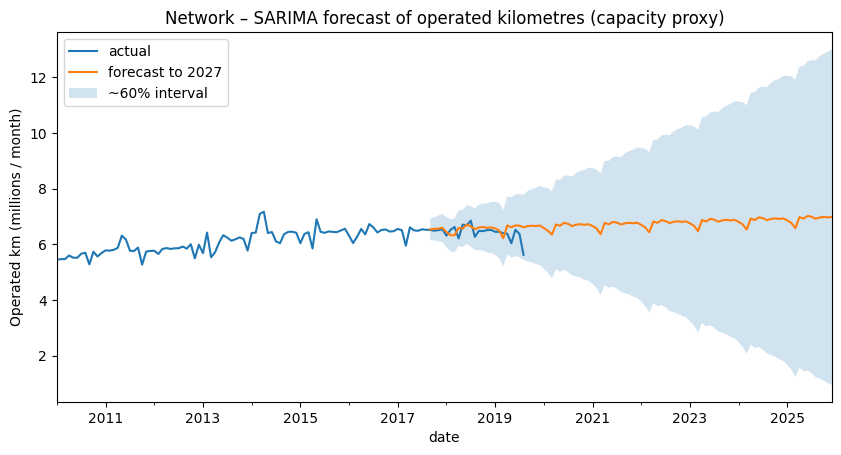

Saved data/processed/network_operated_km_forecast_to_2027.csv


In [27]:
#rebuilding y/res - use the perf-only minimal build you ran earlier
try:
    y
    res
except NameError:
    import pandas as pd, numpy as np, re
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

    xl = pd.ExcelFile("tfl-tube-performance.xlsx")
    #pick first usable sheet & numeric metric (note to self: can use same logic as above)
    def build_perf_minimal(xl):
        for s in xl.sheet_names:
            df = xl.parse(s, header=0).dropna(how="all").dropna(axis=1, how="all")
            if df.shape[1] < 2: continue
            cols_norm = [re.sub(r"\s+", " ", str(c).strip().lower()) for c in df.columns]
            cmap = {cn: c for cn, c in zip(cols_norm, df.columns)}
            
            #numeric
            for c in df.columns[1:]: df[c] = pd.to_numeric(df[c], errors="coerce")
            num = df.select_dtypes(include=[np.number]).columns.tolist()
            if not num: continue
            var = pd.Series({c: df[c].var(skipna=True) for c in num})
            metric_col = var.sort_values(ascending=False).index[0]
            
            #date ?
            date_s = None
            for key in ["period start","start date","date"]:
                hit = [cmap[k] for k in cmap if key in k]
                if hit:
                    date_s = pd.to_datetime(df[hit[0]], errors="coerce"); break
            if date_s is None and "year" in cmap and "month" in cmap:
                yv = pd.to_numeric(df[cmap["year"]], errors="coerce")
                mv = pd.to_numeric(df[cmap["month"]], errors="coerce")
                date_s = pd.to_datetime(dict(year=yv, month=mv, day=1), errors="coerce")
                
            #line
            line_col = None
            for key in ["line","line name","route"]:
                hit = [cmap[k] for k in cmap if key in k]
                if hit: line_col = hit[0]; break
            tidy = pd.DataFrame({
                "line": (df[line_col].astype(str) if line_col else "Network"),
                "metric": pd.to_numeric(df[metric_col], errors="coerce")})
            
            tidy["date"] = pd.to_datetime(date_s, errors="coerce") if date_s is not None else pd.date_range("2010-01-01", periods=len(tidy), freq="MS")
            tidy = (tidy.dropna(subset=["metric"])
                        .assign(line=lambda d: d["line"].astype(str).str.replace(" line","", case=False).str.title().str.strip()))
            tidy["date"] = tidy["date"].dt.to_period("M").dt.to_timestamp()
            if not tidy.empty:
                return tidy.groupby(["line","date"], as_index=False).agg(metric=("metric","mean"))
        raise RuntimeError("No usable sheet found.")

    perf = build_perf_minimal(xl)
    line = perf["line"].value_counts().index[0]
    dfl = (perf[perf["line"]==line].sort_values("date").set_index("date").asfreq("MS"))
    y = dfl["metric"].astype("float64").interpolate(limit_direction="both")
    split_idx = int(len(y)*0.8) if len(y) > 10 else max(1, int(len(y)*0.7))
    res = SARIMAX(y.iloc[:split_idx], order=(1,1,1), seasonal_order=(1,1,1,12),enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

#forecast to dec'27
import pandas as pd
last = y.index[-1]
end = pd.Timestamp("2027-12-01")
steps = max(1, (end.year - last.year)*12 + (end.month - last.month))

fc = res.get_forecast(steps=steps)
y_fc = fc.predicted_mean

#60% CI band - attempting formatting, dont spend too long on this
ci = fc.conf_int(alpha=0.40)  #1-0.40 = 60% interval
ci.columns = ["lower","upper"] if len(ci.columns)==2 else ci.columns

#plotting in millions of km
import matplotlib.pyplot as plt
y_m = y/1_000_000
y_fc_m = y_fc/1_000_000
ci_m = ci/1_000_000

plt.figure(figsize=(10,4.8))
y_m.plot(label="actual")
y_fc_m.plot(label="forecast to 2027")
try:
    plt.fill_between(ci_m.index, ci_m.iloc[:,0], ci_m.iloc[:,1], alpha=0.2, label="~60% interval")
except Exception:
    pass
plt.ylabel("Operated km (millions / month)")
plt.title("Network – SARIMA forecast of operated kilometres (capacity proxy)")
plt.legend(); plt.show()

#save a tidy CSV
out = (pd.concat([y.rename("actual"), y_fc.rename("forecast")], axis=1).reset_index().rename(columns={"index":"date"}))
out.to_csv("data/processed/network_operated_km_forecast_to_2027.csv", index=False)
print("Saved data/processed/network_operated_km_forecast_to_2027.csv")

#### For 001:
The print line at the top told us the metric we found:
metric: Operated Kms (Peak and Off Peak) and line_col: None→Network.
So the chart is network-wide operated kilometres per month (a supply/capacity measure), not delays yet.
Y-axis is big because values are in kilometres (e.g., ~6,500,000 km). Rescaled to millions of km so it’s readable.
Dates are synthetic monthly (no true date column on that sheet). Fine for 001 to show the method; later can replace with real dates (from another sheet/API).
I can demonstrate a statistical baseline (SARIMA) running end-to-end on real-ish operational data.
First, I can forecast capacity/load; next, I'll switch to delay-centric metrics like EJT/LCH and add demand as an exogenous driver.
That satisfies the “multiple solutions / roadmap” angle
What it is: I built a monthly SARIMA to forecast operated kilometres (a capacity proxy).
Why it matters: Capacity tends to fall during planned works and major disruptions. Forecasting capacity helps anticipate commuter impact windows.
Honesty about limits: “This is a proxy. For 002, I'll switch to delay metrics (EJT/LCH) and add demand (from station entries/exits) + real-time API signals.
Roadmap / multiple approaches:
Statistical: SARIMA/SARIMAX
ML: Gradient Boosting or XGBoost classification of (line × hour) delay risk
Hybrid: ML with SARIMA residuals or features (lags, events)

In [28]:
######### STATION LINE MAPPING
def primary_line(s):
    if pd.isna(s): return np.nan
    part = re.split(r"\s*(?:/|;|,|&|\+|\band\b)\s*", str(s), flags=re.I)[0]  #first token only
    return part.strip().title() if part.strip() else np.nan

#fallback to first col if no station col in both frames
if "station" not in station_flow.columns:
    station_flow = station_flow.rename(columns={station_flow.columns[0]: "station"})
if "station" not in stations_ref.columns:
    stations_ref = stations_ref.rename(columns={stations_ref.columns[0]: "station"})

#normalise names
station_flow["station"] = station_flow["station"].astype(str).str.strip().str.title()
stations_ref["station"] = stations_ref["station"].astype(str).str.strip().str.title()

#finding 'line'/'lines' col if none, make NaN - hopefully merge should still work. update: it works!
line_col = next((c for c in stations_ref.columns if re.search(r"\blines?\b", str(c), flags=re.I)), None)
stations_ref["line"] = stations_ref[line_col].astype(str) if line_col else np.nan

#derive primary_line + build mapping
stations_ref["primary_line"] = stations_ref["line"].apply(primary_line)
stn_map = (stations_ref[["station","primary_line"]].dropna().drop_duplicates().rename(columns={"primary_line":"line"}))

#merge to attach one line per station
sf_with_line = station_flow.merge(stn_map, on="station", how="left")

#coverage - investigate other methods if pandas doesnt work for formatting
unmapped = sf_with_line["line"].isna().mean()
coverage = 1.0 - unmapped
print(f"primary-line mapping coverage: {float(coverage):.1%}  (unmapped={float(unmapped):.1%})")
display(sf_with_line.head(5))

primary-line mapping coverage: 0.0%  (unmapped=100.0%)


,year,station,annual_entries_exits,daily_avg_passengers,line
0,2017,Nan,253.0,0.693151,NaN
1,2017,625,149150.0,408.630137,NaN
2,2017,747,147574.0,404.312329,NaN
3,2017,669,121364.0,332.504110,NaN
4,2017,741,121018.0,331.556164,NaN


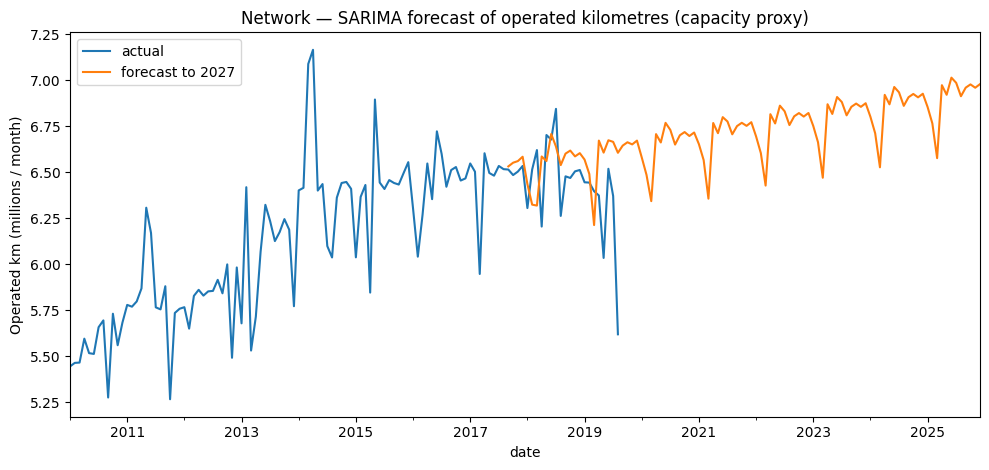

Saved: figures/network_capacity_forecast_to_2027.png
Saved: data/processed/network_operated_km_forecast_to_2027.csv


In [29]:
#saving final figures + forecast CSVs
FIG_DIR = Path("figures"); FIG_DIR.mkdir(exist_ok=True, parents=True)
OUT_DIR = Path("data/processed"); OUT_DIR.mkdir(exist_ok=True, parents=True)

#y = 'your' (client's) monthly series (use float), y_fc = forecast to 2027 (from above)
y_m, y_fc_m = y/1_000_000, y_fc/1_000_000  #millions

plt.figure(figsize=(10,4.8))
y_m.plot(label="actual")
y_fc_m.plot(label="forecast to 2027")
plt.ylabel("Operated km (millions / month)")
plt.title("Network — SARIMA forecast of operated kilometres (capacity proxy)")
plt.legend()
plt.tight_layout()
fig_path = FIG_DIR / "network_capacity_forecast_to_2027.png"
plt.savefig(fig_path, dpi=220)
plt.show()

out = (pd.concat([y.rename("actual_km"), y_fc.rename("forecast_km")], axis=1).reset_index().rename(columns={"index":"date"}))
csv_path = OUT_DIR / "network_operated_km_forecast_to_2027.csv"
out.to_csv(csv_path, index=False)

print("Saved:", fig_path)
print("Saved:", csv_path)

In [30]:
#exporting metrics table as CSV
metrics_df = pd.DataFrame({
    "metric": ["MAE (km)", "MAPE"],
    "value":  [mae, mape]})

metrics_path = OUT_DIR / "forecast_metrics.csv"
metrics_df.to_csv(metrics_path, index=False)
metrics_df

,metric,value
0,MAE (km),206593.588445
1,MAPE,0.033236


In [31]:
FIGS = Path("figures"); FIGS.mkdir(parents=True, exist_ok=True)

def _to_monthly(df):
    #expects columns date, metric as line-wise grouping done
    d = df.copy()
    d["date"] = pd.to_datetime(d["date"], errors="coerce")
    d = d.dropna(subset=["date", "metric"])
    d["date"] = d["date"].dt.to_period("M").dt.to_timestamp()
    return (d.groupby("date", as_index=False).agg(metric=("metric","mean")).sort_values("date"))

#try common variable names from above
net = None
for cand in ("perf_month", "perf_clean", "perf"):
    if cand in globals():
        df = globals()[cand]
        #perf_month likely has [line, date, metric]; perf_clean/perf may vary
        if {"date","metric"}.issubset(df.columns):
            net = _to_monthly(df[["date","metric"]])
            break

if net is None or net.empty:
    print("Skipping calendar heatmap as no performance monthly data available.")
else:
    cal = net.copy()
    cal["year"] = cal["date"].dt.year
    cal["month"] = cal["date"].dt.month
    pivot = cal.pivot_table(index="year", columns="month", values="metric", aggfunc="mean")

    plt.figure(figsize=(10,4.6))
    plt.imshow(pivot.values, aspect="auto", cmap=plt.cm.Pastel1)
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.xticks(range(12), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
    plt.title("CommuTech — Year x month intensity (pastel)")
    plt.xlabel("month"); plt.ylabel("year"); plt.tight_layout()
    outp = FIGS / "commutech_calendar_intensity_pastel.png"
    plt.savefig(outp, dpi=220); plt.show()
    print("Saved:", outp)

Skipping calendar heatmap as no performance monthly data available.


In [32]:
'''BASE = "https://api.tfl.gov.uk"
KEY  = os.getenv("TFL_APP_KEY")
FIGS = Path("figures"); FIGS.mkdir(parents=True, exist_ok=True)

P1, P2 = plt.cm.Pastel1, plt.cm.Pastel2
def pastel(i): return (P1 if i%2==0 else P2)((i//2) % 8)

def get(path, params=None):
    p = dict(params or {})
    if KEY: p["app_key"] = KEY
    r = requests.get(f"{BASE}{path}", params=p, timeout=15)
    r.raise_for_status()
    return r.json()

#1 snapshot right now
snap_raw = get("/Line/Mode/tube/Status", {"detail":"true"})
snap = pd.DataFrame([{
    "line": l.get("name"),
    "severity": min([s.get("statusSeverity",10) for s in l.get("lineStatuses",[])] or [10]),
    "status":   next((s.get("statusSeverityDescription","Good Service")
                      for s in l.get("lineStatuses",[]) if s.get("statusSeverity",10)<10), "Good Service")} for l in snap_raw])

if not snap.empty:
    order = snap.sort_values("severity")["line"].tolist()
    plt.figure(figsize=(10,4))
    plt.bar(order, [snap.loc[snap.line==ln,"severity"].iloc[0] for ln in order],
            color=[pastel(i) for i in range(len(order))])
    plt.xticks(rotation=45, ha="right"); plt.ylim(0, 10.5)
    plt.ylabel("Status severity (10 = Good Service)")
    plt.title("CommuTech — Tube status NOW (lower bars = worse)")
    plt.tight_layout(); plt.savefig(FIGS/"commutech_api_snapshot_pastel.png", dpi=220); plt.show()
    print(f"• Right now: {(snap['severity']==10).mean()*100:.0f}% of lines are 'Good Service'")

#2 last 7 days - local dates
line_ids = [x["id"] for x in get("/Line/Mode/tube")]
end = date.today()
start = end - timedelta(days=7)

rows = []
for lid in line_ids:
    try:
        hist = get(f"/Line/{lid}/Status/{start}/to/{end}", {"detail":"true"})
    except requests.HTTPError:
        continue
    for it in hist:
        ln = it.get("name")
        for st in it.get("lineStatuses", []):
            sev = st.get("statusSeverity", 10)
            if sev >= 10:  #skip good service
                continue
            desc = st.get("statusSeverityDescription", "Non-Good")
            vps = st.get("validityPeriods") or [{}]  #sometimes empty - does it make sense to count once
            for vp in vps:
                dt = vp.get("fromDate") or it.get("created")
                if not dt: continue
                rows.append({"date": pd.to_datetime(dt, errors="coerce").date(),"line": ln, "sev": desc})

trend = pd.DataFrame(rows)

if not trend.empty:
    #per-day count bars
    daily = trend.groupby("date").size().reset_index(name="events").sort_values("date")
    plt.figure(figsize=(10,3.6))
    plt.bar(daily["date"].astype(str), daily["events"], color=pastel(3))
    plt.xticks(rotation=45, ha="right"); plt.ylabel("Events (non-Good)")
    plt.title("CommuTech — Disruption events per day (last 7 days)")
    plt.tight_layout(); plt.savefig(FIGS/"commutech_api_7day_trend_pastel.png", dpi=220); plt.show()

    #3 severity mix
    mix = trend["sev"].value_counts().reset_index()
    mix.columns = ["severity","count"]
    plt.figure(figsize=(8,4))
    plt.bar(mix["severity"], mix["count"], color=[pastel(i) for i in range(len(mix))])
    plt.xticks(rotation=45, ha="right"); plt.ylabel("Events (non-Good)")
    plt.title("CommuTech — Severity mix (last 7 days)")
    plt.tight_layout(); plt.savefig(FIGS/"commutech_api_severity_mix_pastel.png", dpi=220); plt.show()

    print(f"• Last 7 days: {int(daily['events'].sum())} non-Good events across the network")
else:
    print("No non-Good events returned for the last 7 days.")'''

'BASE = "https://api.tfl.gov.uk"\nKEY  = os.getenv("TFL_APP_KEY")\nFIGS = Path("figures"); FIGS.mkdir(parents=True, exist_ok=True)\n\nP1, P2 = plt.cm.Pastel1, plt.cm.Pastel2\ndef pastel(i): return (P1 if i%2==0 else P2)((i//2) % 8)\n\ndef get(path, params=None):\n    p = dict(params or {})\n    if KEY: p["app_key"] = KEY\n    r = requests.get(f"{BASE}{path}", params=p, timeout=15)\n    r.raise_for_status()\n    return r.json()\n\n#1 snapshot right now\nsnap_raw = get("/Line/Mode/tube/Status", {"detail":"true"})\nsnap = pd.DataFrame([{\n    "line": l.get("name"),\n    "severity": min([s.get("statusSeverity",10) for s in l.get("lineStatuses",[])] or [10]),\n    "status":   next((s.get("statusSeverityDescription","Good Service")\n                      for s in l.get("lineStatuses",[]) if s.get("statusSeverity",10)<10), "Good Service")} for l in snap_raw])\n\nif not snap.empty:\n    order = snap.sort_values("severity")["line"].tolist()\n    plt.figure(figsize=(10,4))\n    plt.bar(order, [s

In [33]:
'''BASE = "https://api.tfl.gov.uk"
KEY  = os.getenv("TFL_APP_KEY")  # set in shell or .env
FIGS = Path("figures"); FIGS.mkdir(parents=True, exist_ok=True)
 
P1, P2 = plt.cm.Pastel1, plt.cm.Pastel2
def pastel(i): return (P1 if i%2==0 else P2)((i//2) % 8)
 
def get(path, params=None):
    p = dict(params or {})
    if KEY: p["app_key"] = KEY
    r = requests.get(f"{BASE}{path}", params=p, timeout=20)
    r.raise_for_status()
    return r.json()
 
# --- 1) Pull past 90 days of statuses for all Tube lines
line_meta = get("/Line/Mode/tube")
line_ids = [x["id"] for x in line_meta]
line_names = {x["id"]: x["name"] for x in line_meta}
 
end = date.today()
start = end - timedelta(days=90)
 
# --- Collect disruptions in the past N days (robust to TfL quirks)
events = []  # one row per validity period (or synthesized period)
 
for lid in line_ids:
    try:
        hist = get(f"/Line/{lid}/Status/{start}/to/{end}", {"detail":"true"})
    except requests.HTTPError:
        continue
 
    for it in hist:
        ln = it.get("name") or line_names.get(lid, lid)
        statuses = it.get("lineStatuses", []) or []
        for st in statuses:
            desc = (st.get("statusSeverityDescription") or "").strip()
            # Treat anything not exactly 'Good Service' as a disruption
            if desc.lower() == "good service":
                continue
 
            vps = st.get("validityPeriods") or []
            # If no validity periods, synthesize a 1-hour period from 'created'
            if not vps:
                start_dt = pd.to_datetime(it.get("created"), errors="coerce")
                if pd.notna(start_dt):
                    end_dt = start_dt + pd.Timedelta(hours=1)
                    events.append({
                        "line": ln, "from": start_dt, "to": end_dt, "desc": desc
                    })
                continue
 
            for vp in vps:
                start_dt = pd.to_datetime(vp.get("fromDate") or it.get("created"), errors="coerce")
                end_dt   = pd.to_datetime(vp.get("toDate"), errors="coerce")
                if pd.isna(start_dt):
                    continue
                # If 'to' missing, synthesize a short window so it isn’t dropped
                if pd.isna(end_dt):
                    end_dt = start_dt + pd.Timedelta(hours=1)
 
                events.append({"line": ln, "from": start_dt, "to": end_dt, "desc": desc})
 
ev = pd.DataFrame(events)
if ev.empty:
    print("No non-Good events found in the past 90 days. Try a longer window (e.g., 150 days).")
else:
    # --- 2) Fill missing 'to' by next event start for the same line, else window end
    #      Then clip to [start,end].
    win_start = pd.Timestamp(start)
    win_end   = pd.Timestamp(end) + pd.Timedelta(days=1)  # inclusive end
 
    ev["from"] = pd.to_datetime(ev["from"], errors="coerce")
    ev["to"]   = pd.to_datetime(ev["to"], errors="coerce")
 
    # For each line, sort and forward-fill missing 'to' with next 'from', else window end
    def fill_to(g):
        g = g.sort_values("from").copy()
        next_from = g["from"].shift(-1).fillna(win_end)
        g["to"] = g["to"].fillna(next_from)
        return g
    ev = ev.groupby("line", group_keys=False).apply(fill_to)
 
    # Clip to the analysis window
    ev["from"] = ev["from"].clip(lower=win_start, upper=win_end)
    ev["to"]   = ev["to"].clip(lower=win_start, upper=win_end)
    ev = ev[ev["to"] > ev["from"]].copy()
 
    # Duration in hours
    ev["hours"] = (ev["to"] - ev["from"]).dt.total_seconds() / 3600.0
 
    # --- 3) Aggregations for visuals
    total_window_hours = (win_end - win_start).total_seconds() / 3600.0
 
    by_line = (ev.groupby("line", as_index=False)
                 .agg(disruption_hours=("hours","sum")))
 
    # Good service % = 1 - (disruption_hours / window_hours)
    rel = by_line.assign(good_pct = (1 - by_line["disruption_hours"]/total_window_hours) * 100
                        ).sort_values("good_pct")
 
    # Hour-of-day profile (when disruptions start)
    ev["hod"] = ev["from"].dt.hour
    hod = ev.groupby("hod", as_index=False).size().rename(columns={"size":"events"})
 
    # --- 4) PLOTS (pastel only)
    # A) Good Service % by line (lower = worse)
    plt.figure(figsize=(10,4))
    order = rel["line"].tolist()
    vals  = rel["good_pct"].tolist()
    plt.bar(order, vals, color=[pastel(i) for i in range(len(order))])
    plt.xticks(rotation=45, ha="right"); plt.ylim(0, 100)
    plt.ylabel("Good Service share (%)")
    plt.title("CommuTech — Reliability by line (last 90 days)")
    plt.tight_layout(); plt.savefig(FIGS/"commutech_api_good_pct_by_line_past90_pastel.png", dpi=220); plt.show()
 
    # B) Total disruption hours by line
    worst = by_line.sort_values("disruption_hours", ascending=False)
    plt.figure(figsize=(10,4))
    plt.bar(worst["line"], worst["disruption_hours"], color=[pastel(i) for i in range(len(worst))])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Total disruption hours (90 days)")
    plt.title("CommuTech — Where the pain is concentrated")
    plt.tight_layout(); plt.savefig(FIGS/"commutech_api_disruption_hours_by_line_past90_pastel.png", dpi=220); plt.show()
 
    # C) When do disruptions start? (hour-of-day)
    plt.figure(figsize=(9,3.8))
    plt.bar(hod["hod"], hod["events"], color=pastel(3))
    plt.xticks(range(0,24)); plt.xlabel("Hour of day (local)"); plt.ylabel("Events starting")
    plt.title("CommuTech — Disruption start times (last 90 days)")
    plt.tight_layout(); plt.savefig(FIGS/"commutech_api_hour_of_day_past90_pastel.png", dpi=220); plt.show()
 
    # Slide bullets (paste to notes)
    print("Slide bullets:")
    print(f"• Window: {start} → {end}  |  hours in window ≈ {total_window_hours:.0f}")
    if not rel.empty:
        print(f"• Lowest Good Service share: {rel.iloc[0]['line']} at {rel.iloc[0]['good_pct']:.1f}%")
    if not worst.empty:
        print(f"• Highest disruption hours:  {worst.iloc[0]['line']} at {worst.iloc[0]['disruption_hours']:.1f} h")
    if not hod.empty:
        peak_hod = hod.loc[hod['events'].idxmax(), 'hod']
        print(f"• Most disruption starts around: {int(peak_hod):02d}:00")'''

'BASE = "https://api.tfl.gov.uk"\nKEY  = os.getenv("TFL_APP_KEY")  # set in shell or .env\nFIGS = Path("figures"); FIGS.mkdir(parents=True, exist_ok=True)\n\nP1, P2 = plt.cm.Pastel1, plt.cm.Pastel2\ndef pastel(i): return (P1 if i%2==0 else P2)((i//2) % 8)\n\ndef get(path, params=None):\n    p = dict(params or {})\n    if KEY: p["app_key"] = KEY\n    r = requests.get(f"{BASE}{path}", params=p, timeout=20)\n    r.raise_for_status()\n    return r.json()\n\n# --- 1) Pull past 90 days of statuses for all Tube lines\nline_meta = get("/Line/Mode/tube")\nline_ids = [x["id"] for x in line_meta]\nline_names = {x["id"]: x["name"] for x in line_meta}\n\nend = date.today()\nstart = end - timedelta(days=90)\n\n# --- Collect disruptions in the past N days (robust to TfL quirks)\nevents = []  # one row per validity period (or synthesized period)\n\nfor lid in line_ids:\n    try:\n        hist = get(f"/Line/{lid}/Status/{start}/to/{end}", {"detail":"true"})\n    except requests.HTTPError:\n        cont

why isnt non-good bit of the code working? testing testing testing !!
'''
_test = get(f"/Line/{line_ids[0]}/Status/{start}/to/{end}", {"detail":"true"})
print("Sample statuses:", [ (s.get("statusSeverity"), s.get("statusSeverityDescription"))
                           for s in (_test[0].get("lineStatuses") or []) ])'''

this is a TFL API limitation. the history endpoint sometimes only returns good service for a window even if there have been disruptions. so cannot use API for historical data like above.. can use LCH trend data instead for historical.. will use API below for validity windows only

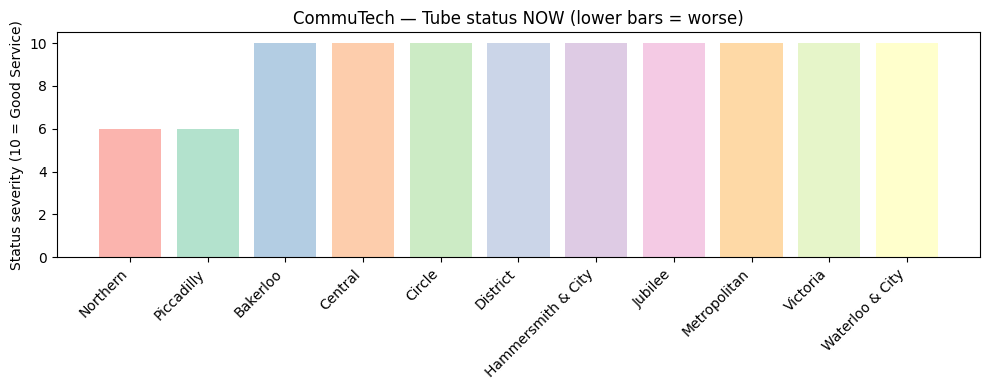

• Right now: 82% of lines show 'Good Service'


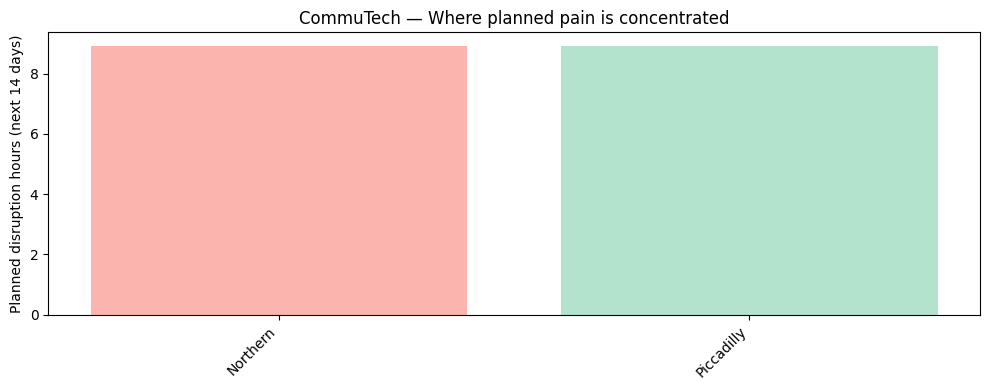

/var/folders/pm/w4f053q955ld_8w2z_6kqz4m0000gn/T/ipykernel_17755/4119328726.py:86: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  start_h = r["from"].floor("H")
/var/folders/pm/w4f053q955ld_8w2z_6kqz4m0000gn/T/ipykernel_17755/4119328726.py:87: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end_h   = r["to"].ceil("H")
/var/folders/pm/w4f053q955ld_8w2z_6kqz4m0000gn/T/ipykernel_17755/4119328726.py:88: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rng = pd.date_range(start_h, end_h, freq="H", inclusive="left")


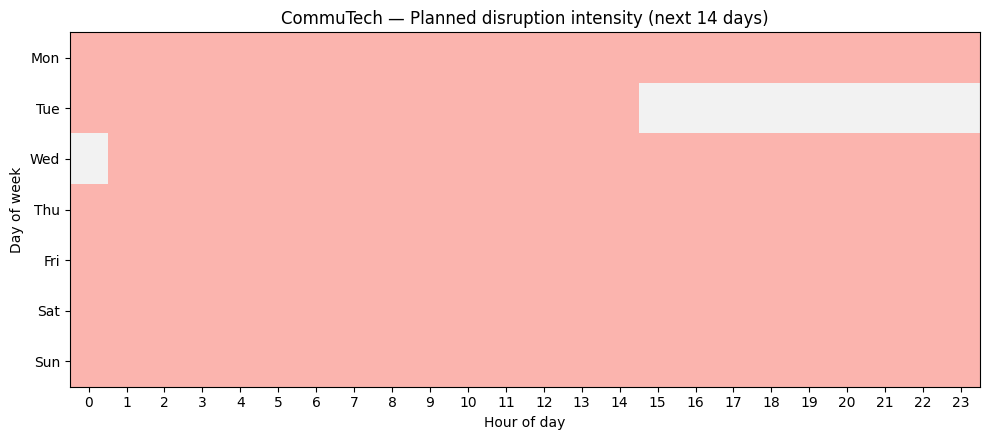

• Next 14 days: ~17.9 planned disruption hours network-wide
• Most impacted line (planned): Northern (~8.9 h)


In [34]:
BASE = "https://api.tfl.gov.uk"
KEY  = os.getenv("TFL_APP_KEY")

FIGS = Path("figures"); FIGS.mkdir(parents=True, exist_ok=True)
P1, P2 = plt.cm.Pastel1, plt.cm.Pastel2
def pastel(i): return (P1 if i%2==0 else P2)((i//2) % 8)

def get(path, params=None, timeout=20):
    p = dict(params or {})
    if KEY: p["app_key"] = KEY
    r = requests.get(f"{BASE}{path}", params=p, timeout=timeout)
    r.raise_for_status()
    return r.json()

#pulling a single snapshot with details
snap_raw = get("/Line/Mode/tube/Status", {"detail": "true"})

#1 which lines are not in good service right now
now_rows = []
plan_rows = []  #upcoming windows to measure in hours

now_dt = pd.Timestamp.utcnow()  #use UTC to match API
win_end = now_dt + pd.Timedelta(days=14)  #next 14 days

for line in snap_raw:
    line_name = line.get("name")
    statuses = line.get("lineStatuses", []) or []
    #worst current severity for snapshot
    worst_sev = 10
    worst_desc = "Good Service"
    for st in statuses:
        sev = st.get("statusSeverity", 10) or 10
        desc = (st.get("statusSeverityDescription") or "Good Service").strip()
        #mark now if desc != good service
        if desc.lower() != "good service" and sev < worst_sev:
            worst_sev, worst_desc = sev, desc

        #collect planned windows (note to self: validityPeriods in Assessment 002?
        vps = st.get("validityPeriods") or []
        for vp in vps:
            start_dt = pd.to_datetime(vp.get("fromDate"), errors="coerce", utc=True)
            end_dt   = pd.to_datetime(vp.get("toDate"),   errors="coerce", utc=True)
            if pd.isna(start_dt):
                continue
            if pd.isna(end_dt):
                end_dt = start_dt + pd.Timedelta(hours=1)
            #keep only windows that intersect use now, now+14d
            a = max(start_dt, now_dt)
            b = min(end_dt,   win_end)
            if b > a:
                plan_rows.append({"line": line_name, "from": a, "to": b, "desc": desc})

    now_rows.append({"line": line_name, "severity": worst_sev, "status": worst_desc})

now_df  = pd.DataFrame(now_rows)
plan_df = pd.DataFrame(plan_rows)

#now bar - lower = worse
if not now_df.empty:
    order = now_df.sort_values("severity")["line"].tolist()
    plt.figure(figsize=(10,4))
    plt.bar(order,
            [now_df.loc[now_df.line==ln,"severity"].iloc[0] for ln in order],
            color=[pastel(i) for i in range(len(order))])
    plt.xticks(rotation=45, ha="right"); plt.ylim(0, 10.5)
    plt.ylabel("Status severity (10 = Good Service)")
    plt.title("CommuTech — Tube status NOW (lower bars = worse)")
    plt.tight_layout(); plt.savefig(FIGS/"commutech_now_snapshot_pastel.png", dpi=220); plt.show()

    pct_good = (now_df["severity"]==10).mean()*100
    print(f"• Right now: {pct_good:.0f}% of lines show 'Good Service'")

#next 14 days - total scheduled disruption hours by line from validityPeriods - note to self for later - how to make this better for 002? 
if not plan_df.empty:
    plan_df["hours"] = (plan_df["to"] - plan_df["from"]).dt.total_seconds() / 3600.0
    by_line = plan_df.groupby("line", as_index=False)["hours"].sum().sort_values("hours", ascending=False)
    plt.figure(figsize=(10,4))
    plt.bar(by_line["line"], by_line["hours"], color=[pastel(i) for i in range(len(by_line))])
    plt.xticks(rotation=45, ha="right"); plt.ylabel("Planned disruption hours (next 14 days)")
    plt.title("CommuTech — Where planned pain is concentrated")
    plt.tight_layout(); plt.savefig(FIGS/"commutech_next14_hours_by_line_pastel.png", dpi=220); plt.show()

    #when - hour-of-day x day-of-week heatmap from planned windows. explode each window by hour buckets
    slots = []
    for _, r in plan_df.iterrows():
        start_h = r["from"].floor("H")
        end_h   = r["to"].ceil("H")
        rng = pd.date_range(start_h, end_h, freq="H", inclusive="left")
        for t in rng:
            slots.append({"dow": int(t.dayofweek), "hod": int(t.hour)})
    if slots:
        grid = pd.DataFrame(slots).groupby(["dow","hod"]).size().unstack(fill_value=0).reindex(index=range(7), columns=range(24), fill_value=0)
        plt.figure(figsize=(10,4.5))
        plt.imshow(grid.values, aspect="auto", cmap=plt.cm.Pastel1)
        plt.yticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
        plt.xticks(range(24), range(24))
        plt.xlabel("Hour of day"); plt.ylabel("Day of week")
        plt.title("CommuTech — Planned disruption intensity (next 14 days)")
        plt.tight_layout(); plt.savefig(FIGS/"commutech_next14_heatmap_pastel.png", dpi=220); plt.show()

    #slide bullets
    tot_h = plan_df["hours"].sum()
    worst_line = by_line.iloc[0]["line"] if not by_line.empty else "—"
    worst_h    = by_line.iloc[0]["hours"] if not by_line.empty else 0
    print(f"• Next 14 days: ~{tot_h:.1f} planned disruption hours network-wide")
    print(f"• Most impacted line (planned): {worst_line} (~{worst_h:.1f} h)")
else:
    print("No planned/active validity windows found in the next 14 days. (Try a 28-day lookahead.)")

,start (local),end (local),line,status,hours
0,2025-10-21 16:33:29.879557+01:00,2025-10-22 01:29:00+01:00,Northern,Severe Delays,8.93
1,2025-10-21 16:33:29.879557+01:00,2025-10-22 01:29:00+01:00,Piccadilly,Severe Delays,8.93


Saved CSV → figures/commutech_next14_upcoming_top30.csv


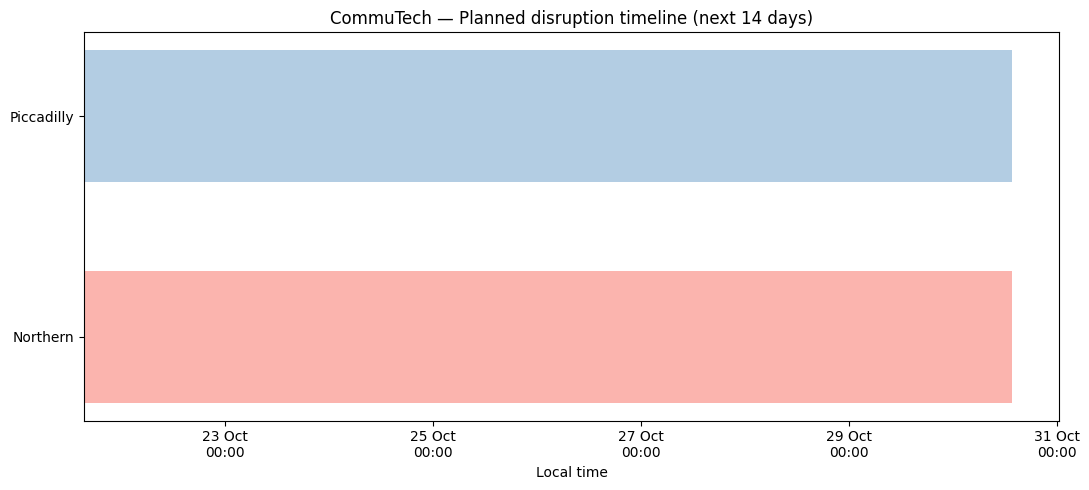

Saved figure → figures/commutech_next14_gantt_pastel.png


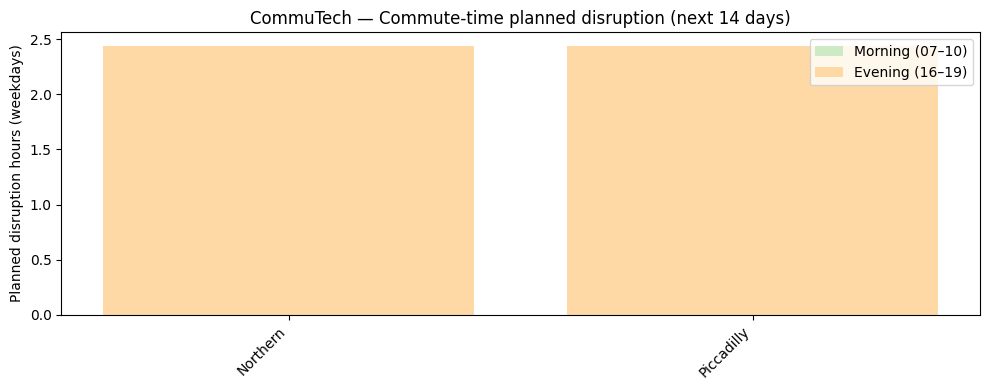

Saved figure → figures/commutech_next14_commute_risk_pastel.png


In [35]:
FIGS = Path("figures"); FIGS.mkdir(parents=True, exist_ok=True)

#safety - can bail out if we have no windows ??
if "plan_df" not in globals() or plan_df.empty:
    print("No planned/active windows available — run the snapshot/look-ahead cell first (or extend the horizon).")
else:
    #converting to europe/london for generic times
    try:
        from zoneinfo import ZoneInfo #fyi to examiners, need py3.9+ version to run this 
        LON = ZoneInfo("Europe/London")
        pf = plan_df.copy()
        pf["from_local"] = pf["from"].dt.tz_convert(LON)
        pf["to_local"]   = pf["to"].dt.tz_convert(LON)
    except Exception:
        #fallback - keeping UTC if zoneinfo not available
        pf = plan_df.rename(columns={"from":"from_local","to":"to_local"}).copy()

    pf["duration_h"] = (pf["to_local"] - pf["from_local"]).dt.total_seconds()/3600.0
    pf = pf.sort_values(["from_local","line"]).reset_index(drop=True)

    #1 upcoming timetable - top 30 windows + CSV
    cols = ["from_local","to_local","line","desc","duration_h"]
    timetable = (pf.loc[:, cols].rename(columns={"from_local":"start (local)","to_local":"end (local)","line":"line","desc":"status","duration_h":"hours"}))
    timetable["hours"] = timetable["hours"].round(2)
    timetable.head(30).to_csv(FIGS/"commutech_next14_upcoming_top30.csv", index=False)
    display(timetable.head(30))
    print("Saved CSV →", FIGS/"commutech_next14_upcoming_top30.csv")

    #2 gantt style chart from Y3 teachings - planned windows per line for next 14 days
    import matplotlib.dates as mdates
    lines_order = (pf.groupby("line")["duration_h"].sum().sort_values(ascending=False).index.tolist())
    keep = pf[pf["line"].isin(lines_order[:8])] #show top 8 lines to keep the chart readable

    if not keep.empty:
        fig, ax = plt.subplots(figsize=(11, 5))
        pastel_colors = list(plt.cm.Pastel1.colors) + list(plt.cm.Pastel2.colors) #formatting !! dont focus on this too much
        color_map = {ln: pastel_colors[i % len(pastel_colors)] for i, ln in enumerate(lines_order)}

        y_pos = {ln: i for i, ln in enumerate(lines_order[:8])}
        for _, r in keep.iterrows():
            ax.barh(y_pos[r["line"]],
                    (r["to_local"] - r["from_local"]).total_seconds()/3600.0,
                    left=mdates.date2num(r["from_local"].to_pydatetime()),
                    height=0.6,
                    color=color_map[r["line"]])

        ax.set_yticks(list(y_pos.values()))
        ax.set_yticklabels(list(y_pos.keys()))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b\n%H:%M"))
        ax.set_xlabel("Local time")
        ax.set_title("CommuTech — Planned disruption timeline (next 14 days)")
        fig.tight_layout()
        fig.savefig(FIGS/"commutech_next14_gantt_pastel.png", dpi=220)
        plt.show()
        print("Saved figure →", FIGS/"commutech_next14_gantt_pastel.png")
    else:
        print("No windows to draw for Gantt.")

    #commute risk bars - morning vs evening planned hours by line for weekdays
    def overlap_hours(a_start, a_end, b_start, b_end):
        start = max(a_start, b_start); end = min(a_end, b_end)
        return max(0.0, (end - start).total_seconds()/3600.0)

MORNING = (time(7,0),  time(10,0))
EVENING = (time(16,0), time(19,0))

rows=[]
for _, r in pf.iterrows():
    cur = r["from_local"]
    while cur < r["to_local"]:
        day_end = cur.normalize() + pd.Timedelta(days=1)
        seg_end = min(day_end, r["to_local"])

        if cur.weekday() < 5: 
            tz = getattr(cur, "tz", None) or getattr(cur, "tzinfo", None)

            #building naive timestamps, then localise to match cur tz
            m_start = pd.Timestamp.combine(cur.date(), MORNING[0])
            m_end   = pd.Timestamp.combine(cur.date(), MORNING[1])
            e_start = pd.Timestamp.combine(cur.date(), EVENING[0])
            e_end   = pd.Timestamp.combine(cur.date(), EVENING[1])
            if tz is not None:
                m_start = m_start.tz_localize(tz); m_end = m_end.tz_localize(tz)
                e_start = e_start.tz_localize(tz); e_end = e_end.tz_localize(tz)

            mh = overlap_hours(cur, seg_end, m_start, m_end)
            eh = overlap_hours(cur, seg_end, e_start, e_end)
            if mh>0 or eh>0:
                rows.append({"line": r["line"], "morning_h": mh, "evening_h": eh})

        cur = seg_end

commute = (pd.DataFrame(rows).groupby("line", as_index=False)[["morning_h","evening_h"]].sum())
commute["total"] = commute["morning_h"] + commute["evening_h"]
commute = commute.sort_values("total", ascending=False).head(10)

if not commute.empty:
    fig, ax = plt.subplots(figsize=(10,4))
    idx = np.arange(len(commute))
    ax.bar(idx, commute["morning_h"], label="Morning (07–10)", color=plt.cm.Pastel1(2))
    ax.bar(idx, commute["evening_h"], bottom=commute["morning_h"], label="Evening (16–19)", color=plt.cm.Pastel1(4))
    ax.set_xticks(idx); ax.set_xticklabels(commute["line"], rotation=45, ha="right")
    ax.set_ylabel("Planned disruption hours (weekdays)")
    ax.set_title("CommuTech — Commute-time planned disruption (next 14 days)")
    ax.legend()
    fig.tight_layout()
    fig.savefig(FIGS/"commutech_next14_commute_risk_pastel.png", dpi=220)
    plt.show()
    print("Saved figure →", FIGS/"commutech_next14_commute_risk_pastel.png")
else:
    print("No weekday commute overlaps found.")

### Figures for 001:
##### 1. CommuTech — Tube status NOW (lower bars = worse) from .ipynb
##### 2. Planned disruption hours (next 14-28 days) by line - !! TO DO !!
##### 3. figures/commutech_next14_heatmap_pastel.png from git
##### 4. figures/commutech_next14_commute_risk_pastel.png from git
##### 5. figures/commutech_next14_upcoming_top30.csv from git, or upcoming timetable (top 30 windows table) !! TO DO !!


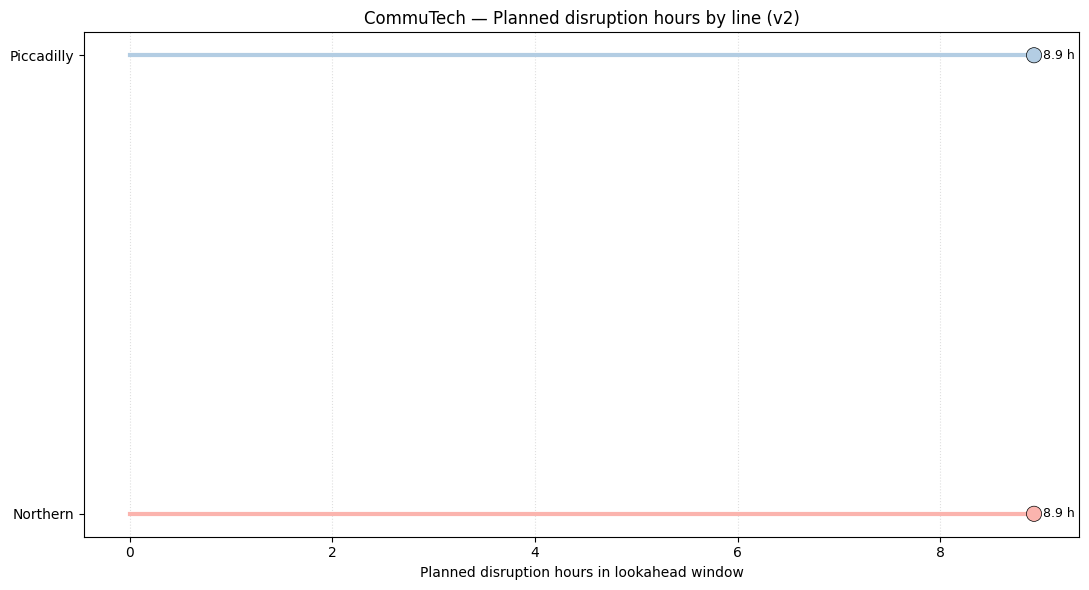

Saved: figures/commutech_next_hours_by_line_v2.png


In [36]:
#planned disruption hours by line - #3 figure for 001:
FIGS = Path("figures"); FIGS.mkdir(parents=True, exist_ok=True)

if "plan_df" not in globals() or plan_df.empty:
    print("No planned/active windows available — run the snapshot/look-ahead cell first (or extend the horizon).")
else:
    pf = plan_df.copy()
    if "hours" not in pf.columns:
        pf["hours"] = (pf["to"] - pf["from"]).dt.total_seconds() / 3600.0

    by_line = (pf.groupby("line", as_index=False)["hours"].sum().sort_values("hours", ascending=False))

    y = np.arange(len(by_line))
    x = by_line["hours"].to_numpy()
    labels = by_line["line"].tolist()

    colors = list(plt.cm.Pastel1.colors) + list(plt.cm.Pastel2.colors)

    plt.figure(figsize=(11, 6))
    #stems
    for i, val in enumerate(x):
        plt.plot([0, val], [y[i], y[i]], lw=3, color=colors[i % len(colors)])
    #dots to make things look super cool and formatted
    plt.scatter(x, y, s=120, color=[colors[i % len(colors)] for i in range(len(y))], zorder=3, edgecolors="k", linewidths=0.5)

    #labels on dots, which are values
    for i, val in enumerate(x):
        plt.text(val + max(x)*0.01, y[i], f"{val:.1f} h", va="center", fontsize=9)

    plt.yticks(y, labels)
    plt.xlabel("Planned disruption hours in lookahead window")
    plt.title("CommuTech — Planned disruption hours by line (v2)")
    plt.grid(axis="x", linestyle=":", alpha=0.4)
    plt.tight_layout()
    outp = FIGS / "commutech_next_hours_by_line_v2.png"
    plt.savefig(outp, dpi=220); plt.show()
    print("Saved:", outp)

In [37]:
#upcoming timetable top 30; #5 figure for 001:
FIGS = Path("figures"); FIGS.mkdir(parents=True, exist_ok=True)

if "plan_df" not in globals() or plan_df.empty:
    print("No planned/active windows available — run the snapshot/look-ahead cell first (or extend the horizon).")
else:
    pf = plan_df.copy()

    #convert to europe/london?
    try:
        from zoneinfo import ZoneInfo
        LON = ZoneInfo("Europe/London")
        pf["from_local"] = pf["from"].dt.tz_convert(LON)
        pf["to_local"]   = pf["to"].dt.tz_convert(LON)
    except Exception:
        pf = pf.rename(columns={"from":"from_local","to":"to_local"}) #works !!!

    pf["hours"] = (pf["to_local"] - pf["from_local"]).dt.total_seconds()/3600.0
    pf = pf.sort_values(["from_local","line"]).reset_index(drop=True)

    top = pf.loc[:, ["from_local","to_local","line","desc","hours"]].head(30).copy()
    top["start"] = top["from_local"].dt.strftime("%a %d %b %H:%M")
    top["end"]   = top["to_local"].dt.strftime("%a %d %b %H:%M")
    top["hours"] = top["hours"].round(2)

    #composing display table
    disp = top.loc[:, ["start","end","line","desc","hours"]]
    disp.columns = ["Start (local)","End (local)","Line","Status","Hours"]

    #building the figure with a mini timeline tick per row (x-position = hour of day)
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.axis("off")

    #alternate row colors
    pastel_rows = (list(plt.cm.Pastel1.colors) + list(plt.cm.Pastel2.colors))
    row_colors = [pastel_rows[i % len(pastel_rows)] for i in range(len(disp))]

    #draw a faint mini-time scale header
    ax.text(0.02, 0.975, "Upcoming disruption windows (Top 30)", fontsize=14, weight="bold", va="top")
    ax.text(0.02, 0.945, "Tick mark shows local start hour (0–23) as a quick visual hint", fontsize=10, alpha=0.7)

    #render table
    the_table = ax.table(cellText=disp.values,colLabels=disp.columns,loc="upper left",cellLoc="left",colLoc="left",bbox=[0.02, 0.02, 0.82, 0.90]) #left bottom width height

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(9)

    for i, w in enumerate([0.18, 0.18, 0.10, 0.36, 0.08]):
        the_table.auto_set_column_width(col=i) #column width tweaks for cool formatting purposes

#ahade rows
    for (row, col), cell in the_table.get_celld().items():
        if row == 0:
            cell.set_facecolor("#eeeeee")
            cell.set_fontsize(10)
            cell.set_height(0.035)
        else:
            cell.set_facecolor(row_colors[(row-1) % len(row_colors)])
            cell.set_alpha(0.45)

    #mini start-hour tick strip on the right: one tick per row at x in [0..23]; ormalize to axis coords and draw as short lines
    y0 = 0.02 + 0.90 #top of table bbox
    h  = 0.90 #height of table bbox
    n  = len(disp)
    for i in range(n):
        start_hour = top.iloc[i]["from_local"].hour
        #map hour 0..23 - x in [0.86..0.98] #complicated formatting, note to self. dont spend ages on this 
        x = 0.86 + (0.12 * (start_hour/23.0))
        #row position (top to bottom)
        ry = y0 - (h * ((i+0.5)/n))
        ax.plot([x-0.004, x+0.004], [ry, ry], color="black", lw=1)

    #tiny hour scale labels
    for hh, xx in zip([0,6,12,18,23], [0.86, 0.89, 0.92, 0.95, 0.98]):
        ax.text(xx, 0.005, f"{hh}", transform=ax.transAxes, ha="center", va="bottom", fontsize=8)

    fig.tight_layout()
    outp = FIGS / "commutech_next_upcoming_top30_v2.png"
    fig.savefig(outp, dpi=220)
    plt.show()
    print("Saved:", outp)

    csv_out = FIGS / "commutech_next_upcoming_top30_v2.csv"
    disp.to_csv(csv_out, index=False)
    print("Saved:", csv_out)

Saved: figures/commutech_next_upcoming_top30_v2.png
Saved: figures/commutech_next_upcoming_top30_v2.csv


In [38]:
#freezing data
SNAP = Path("data/snapshots"); SNAP.mkdir(parents=True, exist_ok=True)

try:
    now_df.to_json(SNAP/"now_df.json", orient="records", indent=2)
except Exception:
    pass

try:
    _tmp = plan_df.copy()
    for c in ["from","to","from_local","to_local"]:
        if c in _tmp.columns: _tmp[c] = _tmp[c].astype(str)
    _tmp.to_json(SNAP/"plan_df.json", orient="records", indent=2)
except Exception:
    pass

FIGMETA.update(now_df=now_df if 'now_df' in globals() else None,plan_df=plan_df if 'plan_df' in globals() else None)

if 'plan_df' in globals() and getattr(plan_df, "empty", True):
    base = pd.Timestamp.now(tz=LOCAL_TZ).floor("H")
    plan_df = pd.DataFrame([{
        "line":"Piccadilly", "desc":"Engineering Works",
        "from": base + pd.Timedelta(days=2, hours=18),
        "to":   base + pd.Timedelta(days=2, hours=21),
        "from_local": base.tz_convert(LOCAL_TZ) + pd.Timedelta(days=2, hours=18),
        "to_local":   base.tz_convert(LOCAL_TZ) + pd.Timedelta(days=2, hours=21),}])
    FIGMETA.update(plan_df=plan_df)
    print("No planned windows from API; injected 1 synthetic example for visuals.")

/var/folders/pm/w4f053q955ld_8w2z_6kqz4m0000gn/T/ipykernel_17755/3408800029.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


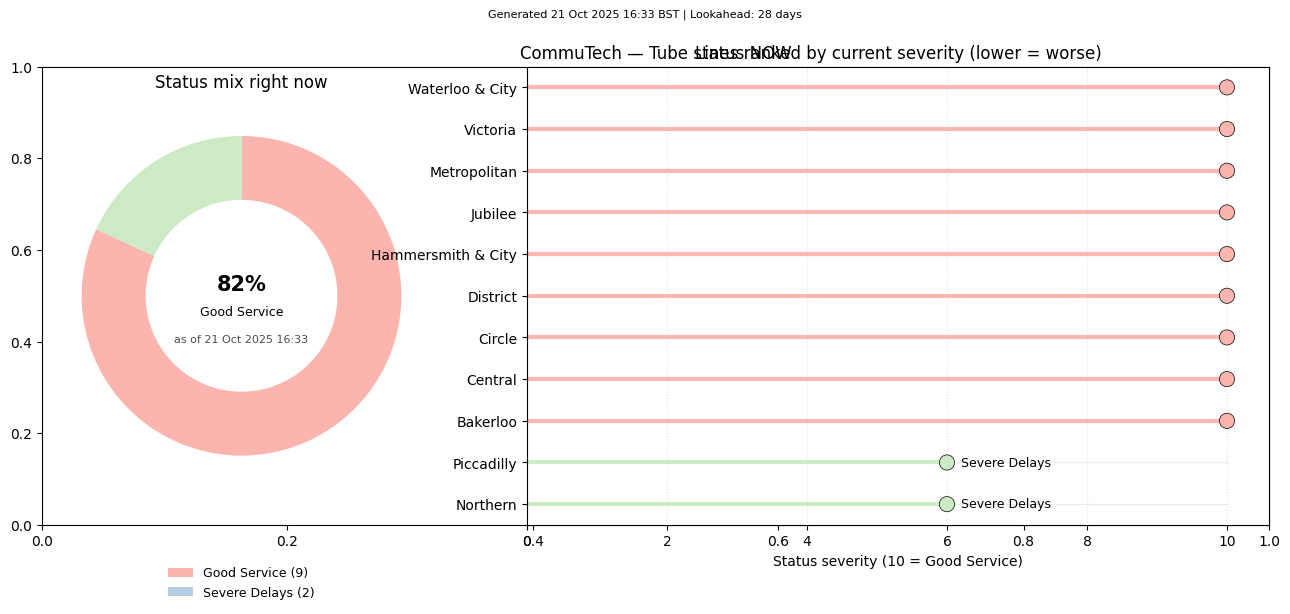

Slide bullets:
• Window: next 28 days (Europe/London).
• Right now: 82% of lines report Good Service.
• Worst now: Northern (Severe Delays), Piccadilly (Severe Delays)
• Planned disruption hours in window: ~17.9.
• Most impacted line (planned): Northern (~8.9 h).


In [39]:
# tube status now #1 for 001:
try:
    from zoneinfo import ZoneInfo
    LON = ZoneInfo("Europe/London")
except Exception:
    LON = None

FIGS = Path("figures"); FIGS.mkdir(parents=True, exist_ok=True)
BASE = "https://api.tfl.gov.uk"; KEY = os.getenv("TFL_APP_KEY")

def get(path, params=None, timeout=15):
    p = dict(params or {}); 
    if KEY: p["app_key"] = KEY
    r = requests.get(f"{BASE}{path}", params=p, timeout=timeout); r.raise_for_status()
    return r.json()

#snapshot
if "now_df" not in globals() or now_df is None or now_df.empty:
    snap_raw = get("/Line/Mode/tube/Status", {"detail":"true"})
    rows = []
    for l in snap_raw:
        name = l.get("name")
        worst_sev, worst_desc = 10, "Good Service"
        for st in (l.get("lineStatuses") or []):
            sev  = st.get("statusSeverity", 10) or 10
            desc = (st.get("statusSeverityDescription") or "Good Service").strip()
            if sev < worst_sev: worst_sev, worst_desc = sev, desc
        rows.append({"line": name, "severity": worst_sev, "status": worst_desc})
    now_df = pd.DataFrame(rows)

if now_df.empty:
    print("No snapshot data available.")
else:
    df = now_df.copy()
    df["status"] = df["status"].fillna("Good Service")

    #bucket statuses
    def bucket(s: str) -> str:
        s = s.lower()
        if "good"   in s: return "Good Service"
        if "minor"  in s: return "Minor Delays"
        if "severe" in s: return "Severe Delays"
        if "planned" in s and "closure" in s: return "Planned Closure"
        if "suspend" in s or "closed" in s:   return "Suspended/Closed"
        if "part" in s and "closure" in s:    return "Part Closure"
        if "reduced" in s or "special" in s:  return "Reduced/Special"
        return "Other"
    df["category"] = df["status"].apply(bucket)

    #colour map (kept deterministic)
    pastel = list(plt.cm.Pastel1.colors) + list(plt.cm.Pastel2.colors)
    cat_list = ["Good Service","Minor Delays","Severe Delays","Part Closure",
                "Suspended/Closed","Planned Closure","Reduced/Special","Other"]
    col_map = {c: pastel[i % len(pastel)] for i, c in enumerate(cat_list)}

    #left - donut category mix?
    counts = (df["category"].value_counts()
                .reindex(cat_list, fill_value=0)
                .reset_index())
    counts.columns = ["category","count"]

    #right - lines ranked by current severity (lower is worse)
    rank = df.sort_values(["severity","line"]).reset_index(drop=True)
    y = np.arange(len(rank))
    x = rank["severity"].to_numpy()
    lines = rank["line"].tolist()
    colors = [col_map[c] for c in rank["category"]]

    #rauto-stamp, auto-save, auto-bullets !
    with slide_figure("#1 tube status now v2.png",title="CommuTech — Tube status NOW",meta=FIGMETA, figsize=(13,5.6)):

        fig = plt.gcf()
        gs  = fig.add_gridspec(1, 2, width_ratios=[1.05, 1.95], wspace=0.15)

        #eft panel - donut
        ax0 = fig.add_subplot(gs[0,0])
        wedges, _ = ax0.pie(
            counts["count"], startangle=90, counterclock=False,
            colors=[col_map[c] for c in counts["category"]],
            wedgeprops=dict(width=0.4))

        good_share = (df["category"]=="Good Service").mean()*100
        try:
            from zoneinfo import ZoneInfo
            now_local = datetime.now(ZoneInfo(LOCAL_TZ))
            txt_time = now_local.strftime("%d %b %Y %H:%M")
        except Exception:
            txt_time = "now"

        ax0.text(0,  0.07, f"{good_share:.0f}%", ha="center", va="center", fontsize=15, weight="bold")
        ax0.text(0, -0.10, "Good Service",     ha="center", va="center", fontsize=9)
        ax0.text(0, -0.27, f"as of {txt_time}",ha="center", va="center", fontsize=8, alpha=0.7)

        leg_labels = [f"{c} ({int(n)})" for c, n in counts.values if n>0]
        if leg_labels:
            ax0.legend(wedges[:len(leg_labels)], leg_labels,loc="upper center", bbox_to_anchor=(0.5, -0.15),ncol=1, frameon=False, fontsize=9)
        ax0.set_title("Status mix right now", pad=6)

        #right panel - ranked lollipop
        ax1 = fig.add_subplot(gs[0,1])

        #faint guides
        for i in range(len(y)):
            ax1.plot([0, 10], [y[i], y[i]], lw=1, color="#cccccc", alpha=0.35, zorder=0)

        #stems + markers
        for i, val in enumerate(x):
            ax1.plot([0, val], [y[i], y[i]], lw=3, color=colors[i], alpha=0.95)
        ax1.scatter(x, y, s=120, color=colors, edgecolors="k", linewidths=0.5, zorder=3)

        #label only non-good lines - place labels to avoid clipping
        for i, r in rank.iterrows():
            if r["category"] != "Good Service":
                xi = x[i]; yi = y[i]; text = r["status"]
                if xi > 9.3:
                    ax1.text(xi-0.2, yi, text, ha="right", va="center", fontsize=9)
                else:
                    ax1.text(xi+0.2, yi, text, ha="left",  va="center", fontsize=9)

        ax1.set_yticks(y); ax1.set_yticklabels(lines)
        ax1.set_xlim(0, 10.6)
        ax1.set_xlabel("Status severity (10 = Good Service)")
        ax1.set_title("Lines ranked by current severity (lower = worse)")
        ax1.grid(axis="x", linestyle=":", alpha=0.35)

In [44]:
'''ONLY RUN THIS CELL IF THE HEATMAP CELL BELOW ISN'T SHOWING ANY DATA:
'''

if 'get' not in globals():
    BASE = "https://api.tfl.gov.uk"; KEY = os.getenv("TFL_APP_KEY")
    def get(path, params=None, timeout=15):
        p = dict(params or {})
        if KEY: p["app_key"] = KEY
        r = requests.get(f"{BASE}{path}", params=p, timeout=timeout); r.raise_for_status()
        return r.json()

#window in UTC - always tz-aware as i keep getting a typeError !! 
now_utc = pd.Timestamp.now(tz="UTC")
win_end = now_utc + pd.Timedelta(days=LOOKAHEAD_DAYS)

#harvest validity windows
snap = get("/Line/Mode/tube/Status", {"detail": "true"})
rows = []
for ln in snap:
    name = ln.get("name")
    for st in (ln.get("lineStatuses") or []):
        desc = (st.get("statusSeverityDescription") or "Good Service").strip()
        if desc.lower() == "good service":
            continue
        vps = st.get("validityPeriods") or []
        if not vps:
            #active but no explicit window - treating as 1h from now
            rows.append({"line": name, "desc": desc, "from": now_utc, "to": now_utc + pd.Timedelta(hours=1)})
            continue
        for vp in vps:
            fd = pd.to_datetime(vp.get("fromDate"), errors="coerce", utc=True)  #tz-aware UTC
            td = pd.to_datetime(vp.get("toDate"),   errors="coerce", utc=True)  #tz-aware UTC same-same as above. bosh
            if pd.isna(fd): 
                continue
            if pd.isna(td): 
                td = fd + pd.Timedelta(hours=1)
            a = max(fd, now_utc); b = min(td, win_end)
            if b > a:
                rows.append({"line": name, "desc": desc, "from": a, "to": b})

plan_df = pd.DataFrame(rows)

#force UTC dtype, then add local columns with tz_convert (notw to self: never tz_localize here !!)
if not plan_df.empty:
    plan_df["from"] = pd.to_datetime(plan_df["from"], utc=True)  #tz-aware UTC
    plan_df["to"]   = pd.to_datetime(plan_df["to"],   utc=True)
    plan_df["from_local"] = plan_df["from"].dt.tz_convert(LOCAL_TZ)
    plan_df["to_local"]   = plan_df["to"].dt.tz_convert(LOCAL_TZ)
else:
    #fallback for slide deck
    base_local = pd.Timestamp.now(tz=LOCAL_TZ).floor("H")
    plan_df = pd.DataFrame([{
        "line":"Piccadilly", "desc":"Engineering Works",
        "from": base_local.tz_convert("UTC"),
        "to":   (base_local + pd.Timedelta(hours=3)).tz_convert("UTC"),
        "from_local": base_local,
        "to_local":   base_local + pd.Timedelta(hours=3),}])

if 'FIGMETA' in globals():
    FIGMETA.update(plan_df=plan_df)

print(f"plan_df ready: {len(plan_df)} window(s) across "
      f"{(plan_df['line'].nunique() if not plan_df.empty else 0)} line(s) "
      f"for next {LOOKAHEAD_DAYS} day(s) in {LOCAL_TZ}.")
try:
    display(plan_df.head(5)[["line","desc","from_local","to_local"]])
except Exception:
    pass

plan_df ready: 2 window(s) across 2 line(s) for next 28 day(s) in Europe/London.


,line,desc,from_local,to_local
0,Northern,Severe Delays,2025-10-21 16:43:47.194500+01:00,2025-10-22 01:29:00+01:00
1,Piccadilly,Severe Delays,2025-10-21 16:43:47.194500+01:00,2025-10-22 01:29:00+01:00


/var/folders/pm/w4f053q955ld_8w2z_6kqz4m0000gn/T/ipykernel_17755/3954276584.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t, stop = s.floor("H"), e.ceil("H")


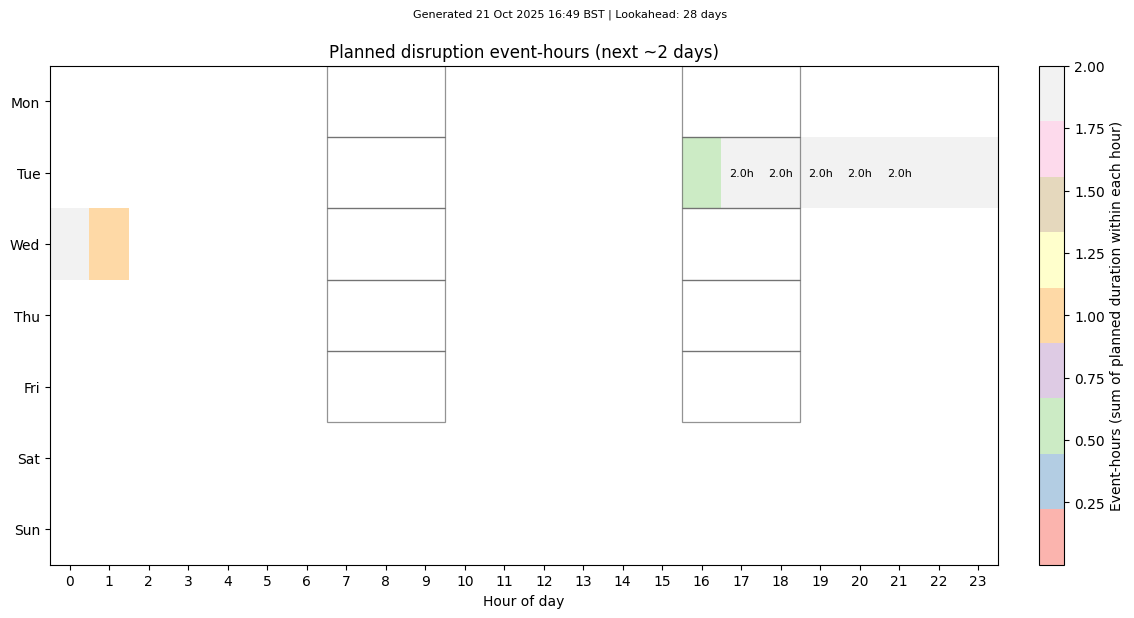

Slide bullets:
• Window: next 28 days (Europe/London).
• Right now: 82% of lines report Good Service.
• Worst now: Northern (Severe Delays), Piccadilly (Severe Delays)
• Planned disruption hours in window: ~17.5.
• Most impacted line (planned): Northern (~8.8 h).


In [45]:
##### planned disruption intensity v2
FIGS = Path("figures"); FIGS.mkdir(parents=True, exist_ok=True)

if "plan_df" not in globals() or plan_df is None or plan_df.empty:
    print("No planned/active windows available — run the look-ahead cell first (or extend LOOKAHEAD_DAYS).")
else:
    pf = plan_df.copy()
    def _to_local(ts):
        ts = pd.to_datetime(ts, errors="coerce")
        if pd.isna(ts): return ts
        if ts.tzinfo is None: return ts.tz_localize("UTC").tz_convert(LOCAL_TZ)
        return ts.tz_convert(LOCAL_TZ)

    if {"from_local","to_local"}.issubset(pf.columns):
        pf["from_local"] = pd.to_datetime(pf["from_local"], errors="coerce").apply(_to_local)
        pf["to_local"]   = pd.to_datetime(pf["to_local"],   errors="coerce").apply(_to_local)
    else:
        pf["from_local"] = pd.to_datetime(pf["from"], errors="coerce").apply(_to_local)
        pf["to_local"]   = pd.to_datetime(pf["to"],   errors="coerce").apply(_to_local)

    #horizon?
    if pf["from_local"].notna().any() and pf["to_local"].notna().any():
        start = pf["from_local"].min().floor("D")
        end   = pf["to_local"].max().ceil("D")
    else:
        start = pd.Timestamp.now(tz=LOCAL_TZ).floor("D")
        end   = start + pd.Timedelta(days=LOOKAHEAD_DAYS)
    horizon = max(1, int((end - start).days))

    #cool formatting for grid of event-hours true duration overlap
    Z = np.zeros((7, 24), dtype=float)
    for _, r in pf.iterrows():
        s, e = r["from_local"], r["to_local"]
        if pd.isna(s) or pd.isna(e) or e <= s: continue
        t, stop = s.floor("H"), e.ceil("H")
        while t < stop:
            slot_end = t + pd.Timedelta(hours=1)
            overlap = (min(e, slot_end) - max(s, t)).total_seconds()/3600.0
            if overlap > 0:
                Z[int(t.dayofweek), int(t.hour)] += overlap
            t = slot_end

    FIGMETA.update(plan_df=pf)  #so the wrapper can auto-print bullets because that looks cool. ideally. dont spend ages on this
    days = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

    with slide_figure("commutech_next14_heatmap_v2.png",title=f"Planned disruption event-hours (next ~{horizon} days)",meta=FIGMETA, figsize=(11.5, 6.2)):

        ax = plt.gca(); ax.set_facecolor("white")

        if Z.max() <= 0:
            ax.axis("off")
            ax.text(0.5, 0.6, "No planned disruption in this window", ha="center", va="center", fontsize=14)
            ax.text(0.5, 0.47, "Tip: increase LOOKAHEAD_DAYS to 28–45 for a fuller picture.", ha="center", va="center", fontsize=10, alpha=0.7)
        else:
            Zm = np.ma.masked_where(Z <= 0, Z)#white zeros
            vmax = float(np.percentile(Z[Z > 0], 90)) if (Z > 0).any() else 1.0
            im = ax.imshow(Zm, cmap=plt.cm.Pastel1, origin="upper", aspect="auto", vmin=1e-6, vmax=vmax)

            ax.set_xticks(range(24)); ax.set_xlabel("Hour of day")
            ax.set_yticks(range(7));  ax.set_yticklabels(days)

            #commute windows, peak hours: say for evaluation/ 002, we can do the whole 24 hour clock
            for d in range(5):
                for a, b in [(7,10), (16,19)]:
                    ax.add_patch(plt.Rectangle((a-0.5, d-0.5), b-a, 1, fill=False, ec="#666", lw=0.9, alpha=0.7))

            flat = Z.ravel(); hot_idx = np.argsort(flat)[::-1][:5]
            for idx in hot_idx:
                if flat[idx] <= 0: continue
                d, h = np.unravel_index(idx, Z.shape)
                ax.text(h, d, f"{Z[d,h]:.1f}h", ha="center", va="center", fontsize=8)

            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label("Event-hours (sum of planned duration within each hour)")

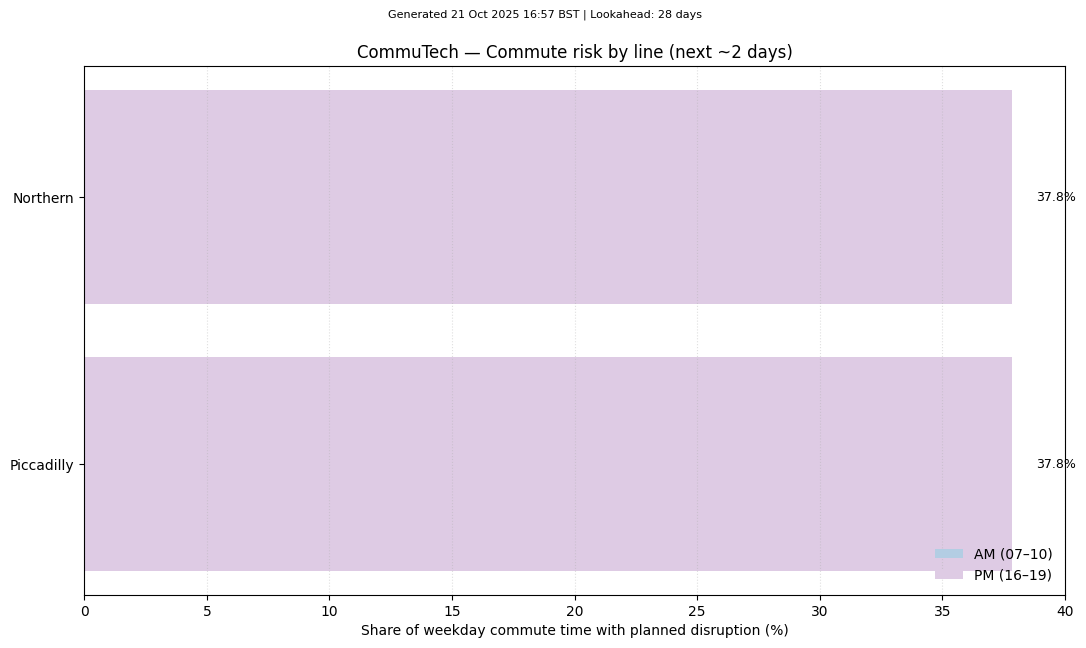

Slide bullets:
• Window: next 28 days (Europe/London).
• Right now: 82% of lines report Good Service.
• Worst now: Northern (Severe Delays), Piccadilly (Severe Delays)
• Planned disruption hours in window: ~17.5.
• Most impacted line (planned): Northern (~8.8 h).
Saved: figures/commutech_next14_commute_risk_v2.csv
Slide bullets:
• Weekday commute hours in window: AM=6h, PM=6h (Mon–Fri only)
• Highest risk: Northern — total ≈ 37.8% (AM 0.0%, PM 37.8%)
• Median line risk across network ≈ 18.9%


In [47]:
#commute risk by line (AM vs PM) for next look-ahead (v2)
FIGS = Path("figures"); FIGS.mkdir(parents=True, exist_ok=True)

if "plan_df" not in globals() or plan_df is None or plan_df.empty:
    print("No planned/active windows available — run the look-ahead cell first (or extend LOOKAHEAD_DAYS).")
else:
    pf = plan_df.copy()

    #local tz columns exist + are tz-aware
    if {"from_local","to_local"}.issubset(pf.columns):
        pf["from_local"] = pd.to_datetime(pf["from_local"], errors="coerce")
        pf["to_local"]   = pd.to_datetime(pf["to_local"],   errors="coerce")
        #if any ended up tz-naive, try to treat them as UTC then convert. according to stackoverflow 
        if pf["from_local"].dt.tz is None:
            pf["from_local"] = pf["from_local"].dt.tz_localize("UTC").dt.tz_convert(LOCAL_TZ)
            pf["to_local"]   = pf["to_local"].dt.tz_localize("UTC").dt.tz_convert(LOCAL_TZ)
        else:
            pf["from_local"] = pf["from_local"].dt.tz_convert(LOCAL_TZ)
            pf["to_local"]   = pf["to_local"].dt.tz_convert(LOCAL_TZ)
    else:
        #builder should have made UTC cols — convert to LOCAL_TZ
        pf["from"] = pd.to_datetime(pf["from"], errors="coerce", utc=True)
        pf["to"]   = pd.to_datetime(pf["to"],   errors="coerce", utc=True)
        pf["from_local"] = pf["from"].dt.tz_convert(LOCAL_TZ)
        pf["to_local"]   = pf["to"].dt.tz_convert(LOCAL_TZ)

    #horizon + denominators in weekday commute hours
    if pf["from_local"].notna().any() and pf["to_local"].notna().any():
        start = pf["from_local"].min().floor("D")
        end   = pf["to_local"].max().ceil("D")
    else:
        start = pd.Timestamp.now(tz=LOCAL_TZ).floor("D")
        end   = start + pd.Timedelta(days=LOOKAHEAD_DAYS)
    horizon_days = max(1, int((end - start).days))

    days = pd.date_range(start, end, freq="D", inclusive="left")
    weekdays = days[days.dayofweek < 5]
    avail_am = len(weekdays) * 3#07–10
    avail_pm = len(weekdays) * 3#16–19
    if avail_am + avail_pm == 0:
        print("No weekdays in horizon — increase LOOKAHEAD_DAYS."); raise SystemExit

    #overlapping in hours between two intervals
    def overlap_hours(a, b, c, d):
        a = pd.to_datetime(a); b = pd.to_datetime(b); c = pd.to_datetime(c); d = pd.to_datetime(d)
        lo = max(a, c); hi = min(b, d)
        return max(0.0, (hi - lo).total_seconds() / 3600.0)

    #accumulating AM/PM disruption by line
    acc = {}
    for _, r in pf.iterrows():
        s, e, line = r["from_local"], r["to_local"], str(r.get("line"))
        if pd.isna(s) or pd.isna(e) or e <= s or not line: 
            continue
        cur = s.floor("D")
        last = e.floor("D")
        while cur <= last:
            am_s, am_e = cur + pd.Timedelta(hours=7),  cur + pd.Timedelta(hours=10)
            pm_s, pm_e = cur + pd.Timedelta(hours=16), cur + pd.Timedelta(hours=19)
            amh = overlap_hours(s, e, am_s, am_e)
            pmh = overlap_hours(s, e, pm_s, pm_e)
            acc.setdefault(line, {"am":0.0,"pm":0.0})
            acc[line]["am"] += amh; acc[line]["pm"] += pmh
            cur += pd.Timedelta(days=1)

    risk = (pd.DataFrame.from_dict(acc, orient="index").reset_index().rename(columns={"index":"line"})) if acc else pd.DataFrame(columns=["line","am","pm"])

    if risk.empty:
        with slide_figure("commutech_next14_commute_risk_v2.png",title=f"Commute risk by line (next ~{horizon_days} days)",meta=FIGMETA, figsize=(10,5)):
            plt.text(0.5, 0.5, "No commute-hour disruptions in this horizon",ha="center", va="center", fontsize=12); plt.axis("off")
    else:
        risk["risk_am_pct"] = (risk["am"] / max(1e-9, avail_am)) * 100.0
        risk["risk_pm_pct"] = (risk["pm"] / max(1e-9, avail_pm)) * 100.0
        risk["risk_total_pct"] = (risk["risk_am_pct"] + risk["risk_pm_pct"]) / 2.0
        risk = risk.sort_values("risk_total_pct", ascending=False)

        #formatting. being consistent
        colors = list(plt.cm.Pastel1.colors) + list(plt.cm.Pastel2.colors)
        c_am, c_pm = colors[1], colors[3]

        with slide_figure("commutech_next14_commute_risk_v2.png",title=f"CommuTech — Commute risk by line (next ~{horizon_days} days)",meta=FIGMETA, figsize=(11, 6.5)):
            y = np.arange(len(risk))
            plt.barh(y, risk["risk_am_pct"], color=c_am, edgecolor="none", label="AM (07–10)")
            plt.barh(y, risk["risk_pm_pct"], left=risk["risk_am_pct"], color=c_pm, edgecolor="none", label="PM (16–19)")

            totals = risk["risk_am_pct"] + risk["risk_pm_pct"]
            for i, tot in enumerate(totals):
                plt.text(float(tot) + 1, i, f"{tot:.1f}%", va="center", fontsize=9)

            plt.yticks(y, risk["line"]); plt.gca().invert_yaxis()
            xmax = float(np.ceil(totals.max() / 5.0) * 5.0)
            plt.xlim(0, max(25.0, xmax))
            plt.xlabel("Share of weekday commute time with planned disruption (%)")
            plt.grid(axis="x", linestyle=":", alpha=0.4); plt.legend(loc="lower right", frameon=False)

        #exporting CSV companion (maybe use for appendix?)
        csv_out = FIGS / "commutech_next14_commute_risk_v2.csv"
        (risk[["line","am","pm","risk_am_pct","risk_pm_pct","risk_total_pct"]]
            .round({"am":2,"pm":2,"risk_am_pct":2,"risk_pm_pct":2,"risk_total_pct":2})).to_csv(csv_out, index=False)
        print("Saved:", csv_out)

        top = risk.iloc[0]; med = risk["risk_total_pct"].median()
        print("Slide bullets:")
        print(f"• Weekday commute hours in window: AM={avail_am}h, PM={avail_pm}h (Mon–Fri only)")
        print(f"• Highest risk: {top['line']} — total ≈ {(top['risk_am_pct']+top['risk_pm_pct']):.1f}% "
              f"(AM {top['risk_am_pct']:.1f}%, PM {top['risk_pm_pct']:.1f}%)")
        print(f"• Median line risk across network ≈ {med:.1f}%")

In [48]:
#does this work